# Question-oriented User Exploration

### python code to generate charts and tables used in deck
https://docs.google.com/presentation/d/168McjSbinm-MamyTAaB8SrZli7cKfwmX1DJWj5F5zTk/edit#slide=id.g50b74851ac_4_31

# 1. Set up environment

### load python packages, custom-defined functions and set up environment

In [1]:
# load all the packages
import pandas as pd
import numpy as np
import datetime
from IPython.display import display
import os.path
from subscription_donation_preprocess import *
from user_exploration_functions import *
#from matplotlib.pyplot import plot
import matplotlib.pyplot as plt
from textwrap import wrap
import itertools
import re
from time import strptime


from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
# to show the whole content in the columns
pd.set_option('display.max_colwidth', -1)

# 2. Data Pre-process
- process three-year donation and subscription files
- process two-year click data and combine into one
- parse click data to extract detailed information from Urls and save as python object


## 2.1 Filter user files and save the data to new files
- remove the last month of data to avoid bias introduced by incomplete last month data
- remove donation records with paid amount euqal to zero???
- save the filtered data as csv files with suffix '_filtered' added to their original file names.

In [2]:
raw_filenames = ['/home/centos/mojo/data/user_data_v2/MJM_datakind.csv',
                 '/home/centos/mojo/data/user_data_v2/DON_datakind.csv',
                 '/home/centos/mojo/data/user_data_v2/SDN_datakind.csv']

date_column = 'ORD ENTR DT'
amt_column = 'AMT PAID'

for f in raw_filenames:
    
    print("processing " + f)
    if '.csv' in f:
        dat = pd.read_csv(f,encoding = "ISO-8859-1")

    if '.xlsx' in f:
        dat = pd.read_excel(f)
        
    dat[date_column] = pd.to_datetime(dat[date_column])
        
    last_date = datetime.datetime((max(dat[date_column])).year,
                                  (max(dat[date_column])).month,                                     
                                   1)
        
    print("remove data later than " + str(last_date) + ": removed " + str(sum(dat[date_column] >last_date)) + " records")
    dat_filtered = dat[dat[date_column] < last_date]
    
    if 'DON' in f or 'SDN' in f:
        print("remove data with AMT PAID = 0"  + ": removed " + str(sum(dat_filtered[amt_column] <= 0)) + " records")
        dat_filtered = dat_filtered[dat_filtered[amt_column] > 0]

    print("create " + f.replace('.csv','_filtered.csv'))
    dat_filtered.to_csv(f.replace('.csv','_filtered.csv'))
    print('\n')

processing /home/centos/mojo/data/user_data_v2/MJM_datakind.csv
remove data later than 2019-01-01 00:00:00: removed 1823 records
create /home/centos/mojo/data/user_data_v2/MJM_datakind_filtered.csv


processing /home/centos/mojo/data/user_data_v2/DON_datakind.csv
remove data later than 2019-01-01 00:00:00: removed 357 records
remove data with AMT PAID = 0: removed 1016 records
create /home/centos/mojo/data/user_data_v2/DON_datakind_filtered.csv


processing /home/centos/mojo/data/user_data_v2/SDN_datakind.csv
remove data later than 2019-01-01 00:00:00: removed 508 records
remove data with AMT PAID = 0: removed 50 records
create /home/centos/mojo/data/user_data_v2/SDN_datakind_filtered.csv




## 2.2 Filter click data files, combine and save the data to a new file

In [5]:
filenames_2017 = ['january','february','april','april 2','may','june','july1','july2','august','septempber','october','november','december']
filenames_2018 = ['january','feb','march','april','may','june','july','august','september','october','november']

path_2017 = '/home/centos/mojo/data/click_data_final/2017_datakind/datakind'
path_2018 = '/home/centos/mojo/data/click_data_final/2018_datakind/datakind'

df = pd.DataFrame()
df_list = []
for f in filenames_2017:
    tmp = pd.read_csv(path_2017 + '/datakind_2017_' + f +'.csv', index_col=None, header=0)
    
    if f == 'septempber':
        f = 'september'
    
    if f == 'feb':
        f = 'february'
        
    tmp['MONTH'] = f
    tmp['YEAR'] = 2017
    
    # convert month name to numeric format and combine month and year and save as datetime
    tmp['file_month'] = datetime.datetime(2017, int(strptime(re.sub('[0-9]+','',f.replace(' ','')),'%B').tm_mon),1)
    df_list.append(tmp) 
    
for f in filenames_2018:
    tmp = pd.read_csv(path_2018 + '/datakind_2018_' + f +'.csv', index_col=None, header=0)
    
    if f == 'septempber':
        f = 'september'
    
    if f == 'feb':
        f = 'february'
        
    tmp['MONTH'] = f
    tmp['YEAR'] = 2018
    
    # convert month name to numeric format and combine month and year and save as datetime
    tmp['file_month'] = datetime.datetime(2018, int(strptime(re.sub('[0-9]+','',f.replace(' ','')),'%B').tm_mon),1)
    df_list.append(tmp)
    
df = pd.concat(df_list)
## preprocessing
# remove irrelevant columns, rename columns
df = df.drop('email', axis=1)
df = df.drop('email hash', axis=1)
df.rename(columns = {'email hashed': 'EMAIL',
                     'url': 'URL'
                     }, inplace=True)
# only www.motherjones.com
email_clean = df[df['URL'].str.contains("www.motherjones.com")]
email_clean.to_csv('email_clean_2017_18')


## 2.3 parse click data to extract detailed information from Urls and save as python object

In [74]:
import os
import pandas as pd
import urllib.parse
from ua_parser import user_agent_parser
from MojoNewsletterClicksParser import MojoNewsletterClicksParser

# read all the csv files into one data frame
cleanfile = 'email_clean_2017_18'
    # read data from file
dat = pd.read_csv(cleanfile)
dat.rename(columns={'URL':'Url','EMAIL':'Email'}, inplace=True)
    
# create an instance of the class MojoNewsletterClicksParser
nl = MojoNewsletterClicksParser(url_df=dat)

# Parse Url, Browser and Recorded On and add parsed info to the original data frame
full_url_df = nl.extend_url_df( nl.url_df,
                                by_date=False,
                                by_url=True,
                                by_domain_type=True,
                                by_ua=False)
full_url_df['file_month'] = pd.to_datetime(dat['file_month'])

# only Urls with www.motherjones.com domain
clean_data = nl.mojo_standard_parser(full_url_df,selected_cols=['Email',
                                                                'Url',
                                                                'domain',
                                                                'domain_type',
                                                                'topic',
                                                                'title',
                                                                'file_month'])

clean_data.to_pickle('newsletter_processed_data_final.pkl')

/home/centos/mojo/mojoenv/lib/python3.4/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning:

Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.



Add protocol, domain, path, query and fragment
                  to the click data
Add domain_type
                  to the click data
subset by domain type mojo_standard: selected 7913804 records out of 8031659 records
Add topic, title to the click data
Add utm_campaign, utm_medium, utm_source to the click data


## 2.4 load and combine all the data


- load subscription and donation data separately.
- group by email and calculate the frequency, recency, date range and money value of subscriptions and donations
- combine processed subscription and donation data
- Then load pre-processed click data
- group by email and count the unique number of urls and topics (both Mojo topicks and LDA topics) the email clicked.
- combine processed subscription and donation data with the aggregated click data to a single wide data frame.


In [2]:
subscription_filenames = ['/home/centos/mojo/data/user_data_v2/MJM_datakind_filtered.csv']
donation_filenames = ['/home/centos/mojo/data/user_data_v2/DON_datakind_filtered.csv',
                      '/home/centos/mojo/data/user_data_v2/SDN_datakind_filtered.csv']

sub_don_combined_filename = '/home/centos/mojo/subscription_donation_processed_data_final.pkl'
click_data_filename = '/home/centos/mojo/newsletter_processed_data_final.pkl'
nmf_feature_filename = '/home/centos/mojo/data/nmf_19_results.csv'
lda_feature_filename = '/home/centos/mojo/data/lda20_results.csv'
sub_don_click_combined_filename = '/home/centos/mojo/subscription_donation_click_combined_data_final.pkl'

# load data if its pickle exists otherwise reprocess the data
if os.path.exists(sub_don_combined_filename):
    combined = pd.read_pickle(sub_don_combined_filename)
    subscription_df = []
    for f in subscription_filenames:
        if '.csv' in f:
            dat = pd.read_csv(f,encoding = "ISO-8859-1")
        if '.xlsx' in f:
            dat = pd.read_excel(f)
        subscription_df.append(dat)
    subscription = pd.concat(subscription_df)

    donation_df = []
    for f in donation_filenames:
        if '.csv' in f:
            dat = pd.read_csv(f,encoding = "ISO-8859-1")
        if '.xlsx' in f:
            dat = pd.read_excel(f)
        donation_df.append(dat)
    donation = pd.concat(donation_df)
    print('load the combined processed subscription and donation data as data frame combined')
else:
    subscription, donation, combined = sub_don_process(subscription_filenames,
                                                       donation_filenames,
                                                       column_names = { 'email':'Hashed Email',
                                                                        'amount':'AMT PAID',
                                                                        'date': 'ORD ENTR DT',
                                                                        'pubcode':'PUB'})

    combined.to_pickle(sub_don_combined_filename)
                      
# reformat some columns    
subscription.rename(columns = {'Hashed Email': 'EMAIL', 'PUB':'ORD-PUB-CODE'}, inplace=True)
subscription['ORD ENTR DT'] = pd.to_datetime(subscription['ORD ENTR DT'])

donation.rename(columns = {'Hashed Email': 'EMAIL', 'PUB':'ORD-PUB-CODE'}, inplace=True)
donation['ORD ENTR DT'] = pd.to_datetime(donation['ORD ENTR DT'])

                      
# created by https://github.com/datakind/mj_user_engagement/blob/tingting/newsletter_clicks_parser/mojo_newsletter_clicks_preprocess.py
click_data = pd.read_pickle(click_data_filename)
# focus on clicks on motherjones.com only
#click_data = click_data[click_data['domain_type'] == 'mojo_standard']

if os.path.exists(sub_don_click_combined_filename):
    sub_don_click_combined = pd.read_pickle(sub_don_click_combined_filename)
    print('load the combined processed subscription, donation and click data as data frame sub_don_click_combined')

else:    
    
    # count # post and # topics clicked by users
    nclicks_by_users = click_data.groupby('Email').agg({'Url': pd.Series.nunique,'topic':pd.Series.nunique})
    nclicks_by_users = nclicks_by_users.reset_index()

    # count # clicks from each topic by users
    nclicks_by_topics = reshape_data_to_wide(click_data,
                                             row = 'Email', 
                                             col = 'topic', 
                                             element = 'Url',
                                             cal = 'sum')
    nclicks_by_topics = nclicks_by_topics.reset_index()
    nclicks_by_topics = nclicks_by_topics.rename(columns = {'':'NA'})
    
    # count # of NMF topics per user (only choose tp 3 NMF topic for post)
    nclicks_by_nmf_topics = cal_nclicks_by_modeling_topics_percentile(
                                       topic_filename = nmf_feature_filename, 
                                       raw_click_data = click_data, 
                                       prefix = 'NMF_', 
                                       topNtopics = 3)
    
    # count # of LDA topics per user (only choose tp 3 LDA topic for post)
    nclicks_by_lda_topics = cal_nclicks_by_modeling_topics_percentile(
                                           topic_filename = lda_feature_filename, 
                                           raw_click_data = click_data, 
                                           prefix = 'LDA_', 
                                           topNtopics = 3)
    # combine the NMF counts and LDA counts
    nclicks_by_modeling_topics = nclicks_by_nmf_topics.merge(nclicks_by_lda_topics, 
                                                             left_on= 'Email', 
                                                             right_on= 'Email', 
                                                             how= 'inner')
    
    nclicks_by_various_topics = nclicks_by_topics.merge(nclicks_by_modeling_topics, 
                                                    left_on= 'Email', 
                                                    right_on= 'Email', 
                                                    how= 'left').fillna(0)
    
    nclicks_by_modeling_topics.to_pickle('nclicks_by_modeling_topics')
    nclicks_by_various_topics.to_pickle('nclicks_by_various_topics')

    sub_don_click_combined_temp = combine_dat_sets(combined, 
                                                   nclicks_by_users, 
                                                   'Email','Email', join_method = 'left')
    sub_don_click_combined_temp2 = combine_dat_sets(sub_don_click_combined_temp, 
                                                    nclicks_by_topics, 
                                                    'Email','Email', join_method = 'left')

    sub_don_click_combined = combine_dat_sets(sub_don_click_combined_temp2, 
                                              nclicks_by_modeling_topics, 
                                              'Email','Email', join_method = 'left')

    sub_don_click_combined = sub_don_click_combined.set_index('Email')

    sub_don_click_combined.to_pickle(sub_don_click_combined_filename)

load the combined processed subscription and donation data as data frame combined
load the combined processed subscription, donation and click data as data frame sub_don_click_combined


In [197]:
sub_don_click_combined.columns

Index(['subs_freq', 'subs_recency', 'subs_range', 'subs_total', 'don_freq',
       'don_recency', 'don_range', 'don_total', 'MJM', 'DON', 'SDN',
       'process_date', 'Url', 'topic', 'NA',
       'DeclineFreeSubscription-Confirmed', 'Russia', 'about', 'author',
       'authors', 'blue-marble', 'category', 'contributor', 'crime-justice',
       'digitalsample', 'environment', 'food', 'kevin-drum', 'media',
       'mediakit', 'mixed-media', 'mojo', 'newsletters', 'politics', 'riff',
       'thank-you-for-sticking-with-us', 'thanks-for-signing-up',
       'tom-philpott', 'topics', 'All', 'NMF_Misc',
       'NMF_Cartoons_and_Entertainment', 'NMF_Trump_and_Putin',
       'NMF_Healthcare', 'NMF_ClimateChange', 'NMF_Investigations',
       'NMF_LegalIssues', 'NMF_Iraq_MiddleEast', 'NMF_NationalPolitics',
       'NMF_Economy', 'NMF_Taxes_and_Budget', 'NMF_RepublicanParty',
       'NMF_Education', 'NMF_Energy_and_Environment', 'NMF_DemocraticParty',
       'NMF_Military', 'NMF_ObamaAdministrat

### The final product of the aggregation process:
data frame 'sub_don_click_combined' with Email as index and columns explained as blow:


|column name| description|
| --- | --- | 
|subs_freq| # subscriptions|
|subs_recency| # days since the latest subscription|
|subs_range| # days between the first and the last subscriptions|
|subs_total|total dollar paid for subscription|
|don_freq|donations|
|don_recency| # days since the latest donation|
|don_range|# days between the first and the last subscriptions|
|don_total|total dollar paid for donation|
|MJM| if the email has pub code MJM |
|DON| if the email has pub code DON |
|SDN| if the email has pub code SDN (recurring donor) |
|process_date| the date when the data is aggregated to calculate the date range |
|Url| # unique urls the email clicked | 
|topic|	# unique topic the email clicked |
|NA| # urls the email clicked for topic 'NA' |	
|DeclineFreeSubscription-Confirmed|	# urls the email clicked for topic 'DeclineFreeSubscription' |
|Russia|# urls the email clicked for topic 'Russia' |
|about|# urls the email clicked for topic 'about' |
|author|# urls the email clicked for topic 'author' |
|authors|# urls the email clicked for topic 'authors' |
|blue-marble|# urls the email clicked for topic 'blue-marble' |
|category|# urls the email clicked for topic 'category' |
|contributor|# urls the email clicked for topic 'contributor' |
|crime-justice|# urls the email clicked for topic 'crime-justice' |
|digitalsample|# urls the email clicked for topic 'digitalsample' |
|environment|# urls the email clicked for topic 'environment' |
|food|# urls the email clicked for topic 'food' |
|kevin-drum|# urls the email clicked for topic 'kevin-drum' |
|media|# urls the email clicked for topic 'media' |
|mediakit|# urls the email clicked for topic 'mediakit' |
|mixed-media|# urls the email clicked for topic 'mixed-media' |
|mojo|# urls the email clicked for topic 'mojo' |
|newsletters|# urls the email clicked for topic 'newsletters' |
|politics|# urls the email clicked for topic 'politics' |
|riff|# urls the email clicked for topic 'riff' |
|thank-you-for-sticking-with-us|# urls the email clicked for topic 'thank-you-for-sticking-with-us' |
|thanks-for-signing-up|# urls the email clicked for topic 'thanks-for-signing-up' |
|tom-philpott|# urls the email clicked for topic 'tom-philpott' |
|topics|# urls the email clicked for topic 'topics' |
|All| # urls the email clicked for all the topics |
|NMF_Misc|# urls the email clicked for this NMF topic |
|NMF_Cartoons_and_Entertainment|# urls the email clicked for this NMF topic | 
|NMF_Trump_and_Putin|# urls the email clicked for this NMF topic |
|NMF_Healthcare|# urls the email clicked for this NMF topic | 
|NMF_ClimateChange|# urls the email clicked for this NMF topic | 
|NMF_Investigations|# urls the email clicked for this NMF topic |
|NMF_LegalIssues|# urls the email clicked for this NMF topic | 
|NMF_Iraq_MiddleEast|# urls the email clicked for this NMF topic | 
|NMF_NationalPolitics|# urls the email clicked for this NMF topic |
|NMF_Economy|# urls the email clicked for this NMF topic | 
|NMF_Taxes_and_Budget|# urls the email clicked for this NMF topic | 
|NMF_RepublicanParty|# urls the email clicked for this NMF topic |
|NMF_Education|# urls the email clicked for this NMF topic | 
|NMF_Energy_and_Environment|# urls the email clicked for this NMF topic | 
|NMF_DemocraticParty|# urls the email clicked for this NMF topic |
|NMF_Military|# urls the email clicked for this NMF topic | 
|NMF_ObamaAdministration|# urls the email clicked for this NMF topic |
|NMF_Women_and_Reproductive_Rights|# urls the email clicked for this NMF topic | 
|NMF_Guns|# urls the email clicked for this NMF topic | 
|LDA_Environment|# urls the email clicked for this LDA topic |
|LDA_Misc1|# urls the email clicked for this LDA topic | 
|LDA_Healthcare|# urls the email clicked for this LDA topic | 
|LDA_Internet_and_Culture|# urls the email clicked for this LDA topic |
|LDA_Economics_and_Taxes|# urls the email clicked for this LDA topic | 
|LDA_Drugs|# urls the email clicked for this LDA topic | 
|LDA_Criminal_Justice|# urls the email clicked for this LDA topic |
|LDA_Corporations_and_Labor|# urls the email clicked for this LDA topic | 
|LDA_Misc2|# urls the email clicked for this LDA topic | 
|LDA_Trump_and_Russia|# urls the email clicked for this LDA topic |
|LDA_Police_and_Prison|# urls the email clicked for this LDA topic | 
|LDA_Trump_and_Natl_Politics|# urls the email clicked for this LDA topic |
|LDA_Obama_and_Dems|# urls the email clicked for this LDA topic | 
|LDA_Race_and_Racism|# urls the email clicked for this LDA topic | 
|LDA_Food|# urls the email clicked for this LDA topic | 
|LDA_Misc3|# urls the email clicked for this LDA topic |
|LDA_Republican_Party|# urls the email clicked for this LDA topic | 
|LDA_Military|# urls the email clicked for this LDA topic | 
|LDA_Education|# urls the email clicked for this LDA topic |
|LDA_National_Politics|# urls the email clicked for this LDA topic |


# 3 Insight Group 1

## 3.1 basic summary of the data (page 3)
- count the number of unique emails by pub code
- calcuate the total amounts by pub code

In [11]:
subscription_counts = basic_counts(subscription)
donation_counts = basic_counts(donation)

subscription_sums = basic_sum(subscription)
donation_sums = basic_sum(donation)

In [12]:
print(subscription_counts)
print(donation_counts)
print(subscription_sums)
print(donation_sums)

{'min_date': Timestamp('2016-01-04 00:00:00'), 'nemails': 80660, 'noverlap': 0, 'nemails_by_pub':               EMAIL
ORD-PUB-CODE       
MJM           80660, 'max_date': Timestamp('2018-12-31 00:00:00')}
{'min_date': Timestamp('2016-01-01 00:00:00'), 'nemails': 69424, 'noverlap': 3219, 'nemails_by_pub':               EMAIL
ORD-PUB-CODE       
DON           62133
SDN           10510, 'max_date': Timestamp('2018-12-31 00:00:00')}
{'min_date': Timestamp('2016-01-04 00:00:00'), 'sumamt': 1657196.2699998457, 'sumamt_by_pub':                 AMT PAID
ORD-PUB-CODE            
MJM           1657196.27, 'max_date': Timestamp('2018-12-31 00:00:00')}
{'min_date': Timestamp('2016-01-01 00:00:00'), 'sumamt': 7832808.0499999905, 'sumamt_by_pub':                 AMT PAID
ORD-PUB-CODE            
DON           5901476.22
SDN           1931331.83, 'max_date': Timestamp('2018-12-31 00:00:00')}


### subscription data basic counts summary

In [13]:
print('### SUBSCRIPTION ###')
print("Data date ranges from {} to {}".format(subscription_counts['min_date'].date(),subscription_counts['max_date'].date()))
print("count of unique emails: {}".format(str(subscription_counts['nemails'])))
print("count of unique emails by pub code:") 
display(subscription_counts['nemails_by_pub'])

print('count of overlap between pub codes: {}'.format(subscription_counts['noverlap']))



### SUBSCRIPTION ###
Data date ranges from 2016-01-04 to 2018-12-31
count of unique emails: 80660
count of unique emails by pub code:


,EMAIL
ORD-PUB-CODE,
MJM,80660


count of overlap between pub codes: 0


### donation data basic counts summary

In [14]:
print('### DONATION ###')
print("Data date ranges from {} to {}".format(donation_counts['min_date'].date(),donation_counts['max_date'].date()))
print("count of unique emails: {}".format(str(donation_counts['nemails'])))
print("count of unique emails by pub code:") 
display(donation_counts['nemails_by_pub'])
print(donation_counts['nemails_by_pub']/donation_counts['nemails'])
print('\n')
print('count of emails having both DON and SDN: {}'.format(donation_counts['noverlap']))
print('%{} donoars have both DON and SDN'. format(round(donation_counts['noverlap']/donation_counts['nemails']*100,2)))

### DONATION ###
Data date ranges from 2016-01-01 to 2018-12-31
count of unique emails: 69424
count of unique emails by pub code:


,EMAIL
ORD-PUB-CODE,
DON,62133
SDN,10510


                 EMAIL
ORD-PUB-CODE          
DON           0.894979
SDN           0.151389


count of emails having both DON and SDN: 3219
%4.64 donoars have both DON and SDN


### Create a Pie chart to present the amount distribution (page 3)

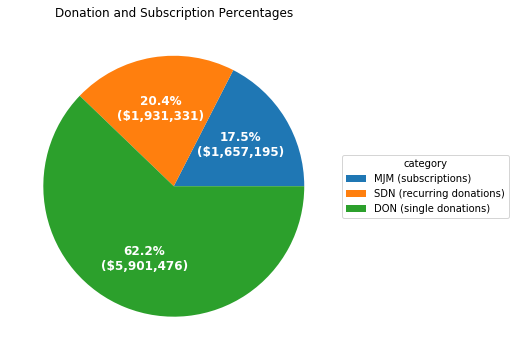

In [15]:
import numpy as np
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(8, 6), subplot_kw=dict(aspect="equal"))

recipe = ["MJM","SDN","DON"]

data = [int(subscription_sums['sumamt_by_pub'].loc['MJM']),
        int(donation_sums['sumamt_by_pub'].loc['SDN']),
        int(donation_sums['sumamt_by_pub'].loc['DON'])]
labels = ['MJM (subscriptions)','SDN (recurring donations)','DON (single donations)']

def func(pct, allvals):
    absolute = int(pct/100.*np.sum(allvals))
    return "{:.1f}%\n(${:,})".format(pct, absolute)


wedges, texts, autotexts = ax.pie(data, autopct=lambda pct: func(pct, data),
                                  textprops=dict(color="w"))

ax.legend(wedges, labels,
          title="category",
          loc="center left",
          bbox_to_anchor=(1, 0, 0.5, 1))

plt.setp(autotexts, size=12, weight="bold")

ax.set_title("Donation and Subscription Percentages")

plt.show()

## 3.2 Create State Map for donation and subscription (page 3 -4)
- subset data to only include US data
- aggregate by state and count total amt paid and number of unique emails 

In [7]:
# load state abbr and their 18+ population 
state_population = pd.read_csv('/home/centos/mojo/state_population.csv')
state_population['pct'] = state_population['pop']/sum(state_population['pop'])

# subset donation to only include US data
# aggregate by state and count total amt paid and number of unique emails
# calculate amount pct by state and donor pct by state
# calculate index = donor pct by state / state population pct
df = donation[donation.COUNTRY =='UNITED STATES'].groupby('STATE').agg({'AMT PAID':'sum', 'EMAIL': 'nunique'})
df = df.reset_index()
df['amt_pct'] = df['AMT PAID']/sum(df['AMT PAID'])
df['num_pct'] = df['EMAIL']/sum(df['EMAIL'])
df = df.merge(state_population, left_on='STATE', right_on = 'state')
df['num_index'] = df['num_pct']/df['pct']

# subset subscription to only include US data
# aggregate by state and count total amt paid and number of unique emails
# calculate amount pct by state and subscriber pct by state
# calculate index = subscriber pct by state / state population pct
df2 = subscription[subscription.COUNTRY =='UNITED STATES'].groupby('STATE').agg({'AMT PAID':'sum', 'EMAIL': 'nunique'})
df2 = df2.reset_index()
df2['amt_pct'] = df2['AMT PAID']/sum(df2['AMT PAID'])
df2['num_pct'] = df2['EMAIL']/sum(df2['EMAIL'])
df2 = df2.merge(state_population, left_on='STATE', right_on = 'state')
df2['num_index'] = df2['num_pct']/df2['pct']


In [8]:
amt_US_pct = sum(donation[donation.COUNTRY =='UNITED STATES']['AMT PAID'])/sum(donation['AMT PAID'])
print("""{}% donation are from US""".format(round(amt_US_pct*100,2)))

92.59% donation are from US


In [9]:
US_donors_pct = len(donation[donation.COUNTRY =='UNITED STATES']['EMAIL'].unique())/len(donation['EMAIL'].unique())
print("""{}% donors are from US""".format(round(US_donors_pct*100,2)))

90.74% donors are from US


In [10]:
US_subscribers_pct = len(subscription[subscription.COUNTRY =='UNITED STATES']['EMAIL'].unique())/len(subscription['EMAIL'].unique())
print("""{}% subscribers are from US""".format(round(US_subscribers_pct*100,2)))

94.44% subscribers are from US


### plot Donation Amount by State

In [11]:
fig = plot_statemap( map_title = 'Donation Amount by State (2016-2018)',
                     bar_title = 'Donation $',
                     states = df['STATE'],
                     values = df['AMT PAID'])
 py.iplot( fig, filename='d3-cloropleth-map' )

### Plot the number of Donors by State

In [12]:
fig = plot_statemap( map_title = 'The number of Donors by State (2016-2018)',
                   bar_title = '# donors',
                   states = df['STATE'],
                   values = df['EMAIL'])
py.iplot( fig, filename='d3-cloropleth-map' )

### Plot Donor Number Index by state

In [13]:
fig = plot_statemap( map_title = 'Donor Number Index by state (weighted by state 18+ population)(2016-2018)',
                     bar_title = 'donor # index',
                     states = df['STATE'],
                     values = df['num_index'] )
py.iplot( fig, filename='d3-cloropleth-map' )

### Plot the number of Subscribers by State

In [14]:
fig = plot_statemap( map_title = 'The number of Subscribers by State (2016-2018)',
                   bar_title = '# subscribers',
                   states = df2['STATE'],
                   values = df2['EMAIL']
                 )
py.iplot( fig, filename='d3-cloropleth-map' )

### plot Subscriber Number Index by state

In [15]:
fig = plot_statemap( map_title = 'Subscriber Number Index by state (weighted by state 18+ population)(2016-2018)',
                     bar_title = 'Subscriber # index',
                    states = df2['STATE'],
                    values = df2['num_index']
                 )
py.iplot( fig, filename='d3-cloropleth-map' )

## 3.3 Summary of the overlap between donors and subscribers 

- Which donors are also subscribers and vice versa? (page 5)
- create confusion matrix between donors and subscribers and find overlap

In [16]:
combined_cf = pd.crosstab(combined['subs_freq'].astype('bool'), 
                          combined['don_freq'].astype('bool'), 
                          rownames=['subscription'], 
                          colnames=['donation'], margins=True)
print('confusion matrix of magazine subscription and donation')
print('\n')
print(combined_cf)
print('\n')
print('{}% of magazine subscribers also donated'.format(round(100*combined_cf.iloc[1,1]/combined_cf.iloc[1,2])))
print('{}% of magazine subscribers also are recurring donors'.format(round(100*sum(combined[(combined['subs_freq'] > 0) & (combined['don_freq'] > 0)]['SDN'])/combined_cf.iloc[1,2])))

print('{}% of donors are magazine subscribers'.format(round(100*combined_cf.iloc[1,1]/combined_cf.iloc[2,1])))

don_clicked_url = sum((sub_don_click_combined['don_freq'] > 0) & (sub_don_click_combined['Url']>0))
total_donor = sum(sub_don_click_combined['don_freq'] > 0)

print('Also, {} donors clicked newsletter ({}%)'.format(don_clicked_url,round(don_clicked_url/total_donor*100,2)))
    

confusion matrix of magazine subscription and donation


donation      False   True     All
subscription                      
False         0      47146  47146 
True          58382  22278  80660 
All           58382  69424  127806


28.0% of magazine subscribers also donated
8.0% of magazine subscribers also are recurring donors
32.0% of donors are magazine subscribers
Also, 21183 donors clicked newsletter (30.51%)


### analyze the overlap change by year (page 5)

In [17]:
import numpy
unique_years = subscription['ORD ENTR DT'].dt.year.unique()

overlap_by_year = {'year':[],'overlap':[],'nsub':[],'ndon':[]}

for single_year in unique_years:
    single_sub = subscription[subscription['ORD ENTR DT'].dt.year == single_year].EMAIL.unique()
    single_don = donation[donation['ORD ENTR DT'].dt.year == single_year].EMAIL.unique()
    overlap_by_year['year'].append(single_year)
    
    noverlap = len(numpy.intersect1d(single_sub,single_don))
    nsub = len(single_sub)
    ndon = len(single_don)

    overlap_by_year['overlap'].append(noverlap)
    overlap_by_year['nsub'].append(nsub)
    overlap_by_year['ndon'].append(ndon)
    
df = pd.DataFrame.from_dict(overlap_by_year)
df['sub_pct'] = ['{:.1%}'.format(x) for x in df['overlap']/df['nsub']]
df['don_pct'] = ['{:.1%}'.format(x) for x in df['overlap']/df['ndon']]

df = df[['year','ndon','nsub','overlap','sub_pct','don_pct']]

df = df.rename(columns={'ndon':'# donors','nsub':'# subscribers',
                  'overlap':'# overlap','sub_pct':'% subscribers who donated','don_pct':'% donors who subscribed'})

df.style.set_table_styles([dict(selector="th",props=[('max-width', '100px')])])

,year,# donors,# subscribers,# overlap,% subscribers who donated,% donors who subscribed
0,2016,30897,36368,8383,23.1%,27.1%
1,2017,35715,49143,10818,22.0%,30.3%
2,2018,36321,40741,10292,25.3%,28.3%


## 3.4 transition between donors and subscribers
### If people both donated and subcribed, did they donate first or subscribe first? How many days between the two actions? (page 6)

In [18]:
both_donor_sub = sub_don_click_combined[(sub_don_click_combined['subs_freq'] > 0) & (sub_don_click_combined['don_freq'] > 0)]
both_donor_sub['earliest_don'] = both_donor_sub['don_range'] +  both_donor_sub['don_recency']
both_donor_sub['earliest_sub'] = both_donor_sub['subs_range'] +  both_donor_sub['subs_recency']

both_donor_sub['earliest_don_date'] = both_donor_sub['process_date'] + [datetime.timedelta(days = -x) for x in both_donor_sub['earliest_don']]
both_donor_sub['earliest_sub_date'] = both_donor_sub['process_date'] + [datetime.timedelta(days = -x) for x in both_donor_sub['earliest_sub']]


both_donor_sub = both_donor_sub[['earliest_don','earliest_sub','earliest_don_date','earliest_sub_date']]
both_donor_sub = both_donor_sub.reset_index()

/home/centos/mojo/mojoenv/lib/python3.4/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/home/centos/mojo/mojoenv/lib/python3.4/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/home/centos/mojo/mojoenv/lib/python3.4/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pand

In [19]:
def transition_type(earliest_don, earliest_sub):
    if earliest_don > earliest_sub:
        return 'Donate first'
    if earliest_don < earliest_sub:
        return 'Subscribe first'
    if earliest_don == earliest_sub:
        return 'Donate and subscribe on the same day'
 

both_donor_sub['transition_type'] = both_donor_sub.apply(lambda x: transition_type(x[1],x[2]), axis=1)
both_donor_sub['transition_period'] = abs(both_donor_sub['earliest_don'] - both_donor_sub['earliest_sub'])
both_donor_sub_transition = both_donor_sub.groupby('transition_type').agg({'Email':'count','transition_period':'median'})
both_donor_sub_transition = both_donor_sub_transition.rename(columns = {'Email': 'email count',
                                             'transition_period': 'average days between transition'})
both_donor_sub_transition['email pct (%)'] = round(both_donor_sub_transition['email count']/both_donor_sub_transition['email count'].sum()*100,2)
both_donor_sub_transition[['email pct (%)','average days between transition']]

,email pct (%),average days between transition
transition_type,,
Donate and subscribe on the same day,29.90,0.0
Donate first,43.20,38.0
Subscribe first,26.89,196.0


## 3.5 magazine subscription renew rate
### check how many magazine subscribers renewed (page 9)

In [20]:
# exclude users who subscribed the first time within a year
blacklist_emails = combined[(combined['subs_freq'] ==1) & (combined['subs_recency']<360)]
potential_renew_subscribers = combined[(combined['subs_freq'] >0 ) & (~combined['Email'].isin(blacklist_emails['Email']))]

renew_rate = ((potential_renew_subscribers['subs_freq']> 1) & (potential_renew_subscribers['subs_range']> 300)).mean()
# assume people only renew within 60 days of expiration
print("magazine renew rate is " + str(round(renew_rate*100,2)) + '%')

magazine renew rate is 41.46%


## 3.6 donation distribution

### analyze the relationship between cumulative donation and cumulative email freq for donation below $1000 (page 7)

In [21]:
## function to calculate cumulative donation and donors
def don_email_cumpct(dat):
    dat_cnts = dat.groupby('don_total').agg({'Email': 'count'})
    dat_cnts = dat_cnts.reset_index()
    dat_cnts['Email_cumpct'] = 100*(dat_cnts['Email']/dat_cnts['Email'].sum()).cumsum()
    dat_cnts['don_total_cum'] = dat_cnts['don_total']*dat_cnts['Email']
    dat_cnts['don_total_cumpct'] = 100*(dat_cnts['don_total_cum'].cumsum())/(dat_cnts['don_total_cum'].sum())
    return dat_cnts


In [22]:
cnts = don_email_cumpct(dat = combined[(combined['don_freq'] > 0)])
cnts.head()

,don_total,Email,Email_cumpct,don_total_cum,don_total_cumpct
0,0.01,6,0.008643,0.06,7.660088e-07
1,0.03,1,0.010083,0.03,1.149013e-06
2,0.05,2,0.012964,0.10,2.425695e-06
3,0.09,1,0.014404,0.09,3.574708e-06
4,0.10,1,0.015845,0.10,4.851389e-06


913    96.881482
Name: Email_cumpct, dtype: float64
913    70.61925
Name: don_total_cumpct, dtype: float64


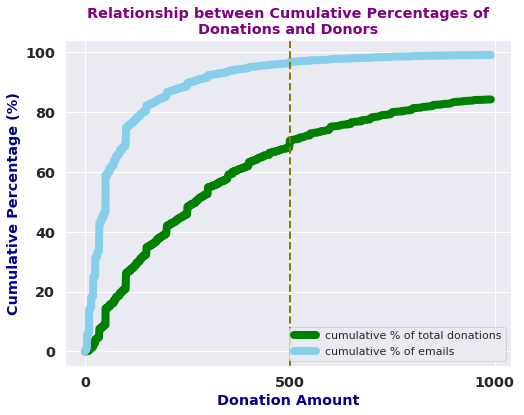

In [23]:
import seaborn as sns; 
sns.set()
import matplotlib.pyplot as plt
                                                                                                                                                       
plt.rcParams['figure.figsize'] = [8, 6]
plt.plot( 'don_total', 
         'don_total_cumpct', 
         data=cnts[cnts['don_total'] < 1000], 
         marker='', markerfacecolor='green', markersize=12, color='green', linewidth=8)
plt.plot( 'don_total', 'Email_cumpct',data=cnts[cnts['don_total'] < 1000], marker='', color='skyblue', linewidth=8)
plt.legend(labels = ['cumulative % of total donations','cumulative % of emails'])
plt.grid(True)
plt.title("\n".join(wrap("Relationship between Cumulative Percentages of Donations and Donors",50)),fontweight='bold', color = 'purple', fontsize = 'large')
plt.xlabel("Donation Amount",fontweight='bold', color = 'darkblue', fontsize = 'large')
plt.ylabel("Cumulative Percentage (%)",fontweight='bold', color = 'darkblue', fontsize = 'large')
plt.xticks([0,500,1000],fontweight='bold', fontsize = 'large')
plt.yticks(np.arange(0, 101, step=20),fontweight='bold', fontsize = 'large')
plt.axvline(x=500, linestyle = '--',color='olive', linewidth=2)
print(cnts['Email_cumpct'][cnts['don_total']==500])
print(cnts['don_total_cumpct'][cnts['don_total']==500])

## 3.7 compare donation distribution among subscribers vs non-subscribers  (page 8)

In [24]:
donor_subscriber_cnts = don_email_cumpct(dat = combined[(combined['don_freq'] > 0) & (combined['subs_freq'] > 0)])
donor_nonsubscriber_cnts = don_email_cumpct(dat = combined[(combined['don_freq'] > 0) & (combined['subs_freq'] == 0)])

donor_subscriber_cnts_below1000 = donor_subscriber_cnts[donor_subscriber_cnts.don_total < 1000]
donor_nonsubscriber_cnts_below1000 = donor_nonsubscriber_cnts[donor_nonsubscriber_cnts.don_total < 1000]

473    96.70527
Name: Email_cumpct, dtype: float64
473    75.519468
Name: don_total_cumpct, dtype: float64
774    96.964748
Name: Email_cumpct, dtype: float64
774    68.202699
Name: don_total_cumpct, dtype: float64


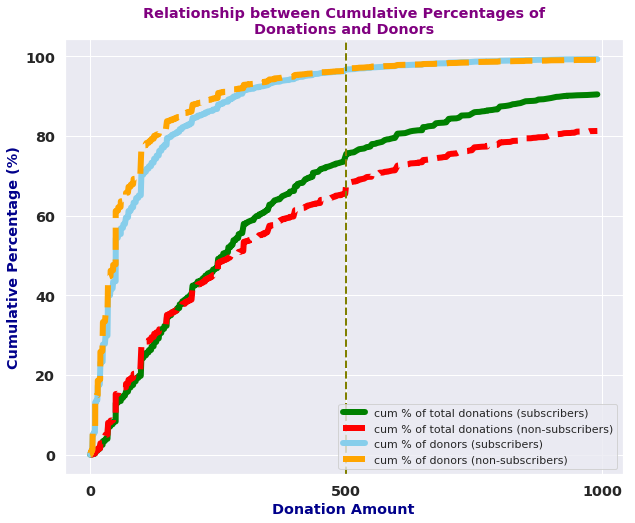

In [25]:
#import seaborn as sns; 
#sns.set()
import matplotlib.pyplot as plt
                                                                                                                                                       
plt.rcParams['figure.figsize'] = [10, 8]
plt.plot( 'don_total', 'don_total_cumpct', 
         data = donor_subscriber_cnts_below1000, 
         marker='', markerfacecolor='green', markersize=10, color='green', linewidth=6, linestyle = 'solid')

plt.plot( 'don_total', 'don_total_cumpct',
         data = donor_nonsubscriber_cnts_below1000, 
         marker='', color='red', linewidth=6, linestyle = 'dashed')

plt.plot( 'don_total', 'Email_cumpct',
         data = donor_subscriber_cnts_below1000, 
         marker='', color='skyblue', linewidth=6, linestyle = 'solid')

plt.plot( 'don_total', 'Email_cumpct',
         data = donor_nonsubscriber_cnts_below1000, 
         marker='', color='orange', linewidth=6, linestyle = 'dashed')

plt.legend(labels = ['cum % of total donations (subscribers)',
                     'cum % of total donations (non-subscribers)',
                     'cum % of donors (subscribers)',
                     'cum % of donors (non-subscribers)'
                    ])
plt.grid(True)
plt.title("\n".join(wrap("Relationship between Cumulative Percentages of Donations and Donors",50)),fontweight='bold', color = 'purple', fontsize = 'large')
plt.xlabel("Donation Amount",fontweight='bold', color = 'darkblue', fontsize = 'large')
plt.ylabel("Cumulative Percentage (%)",fontweight='bold', color = 'darkblue', fontsize = 'large')
plt.xticks([0,500,1000],fontweight='bold', fontsize = 'large')
plt.yticks(np.arange(0, 101, step=20),fontweight='bold', fontsize = 'large')
plt.axvline(x=500, linestyle = '--',color='olive', linewidth=2)

print(donor_subscriber_cnts_below1000['Email_cumpct'][donor_subscriber_cnts_below1000['don_total']==500])
print(donor_subscriber_cnts_below1000['don_total_cumpct'][donor_subscriber_cnts_below1000['don_total']==500])

print(donor_nonsubscriber_cnts_below1000['Email_cumpct'][donor_nonsubscriber_cnts_below1000['don_total']==500])
print(donor_nonsubscriber_cnts_below1000['don_total_cumpct'][donor_nonsubscriber_cnts_below1000['don_total']==500])

In [26]:
print(donor_subscriber_cnts['Email_cumpct'][donor_subscriber_cnts['don_total']==1000])
print(donor_subscriber_cnts['don_total_cumpct'][donor_subscriber_cnts['don_total']==1000])

print(donor_nonsubscriber_cnts['Email_cumpct'][donor_nonsubscriber_cnts['don_total']==1000])
print(donor_nonsubscriber_cnts['don_total_cumpct'][donor_nonsubscriber_cnts['don_total']==1000])

569    99.407487
Name: Email_cumpct, dtype: float64
569    91.453453
Name: don_total_cumpct, dtype: float64
916    99.329742
Name: Email_cumpct, dtype: float64
916    83.205865
Name: don_total_cumpct, dtype: float64


In [27]:
print(sum(donor_subscriber_cnts['don_total_cum']))
print(sum(donor_nonsubscriber_cnts['don_total_cum']))

2586986.440000001
5245821.609999994


## 3.8 Campaign Effectiveness Analysis

### Campaign Effectiveness Analysis (page 10-11) 
#### group donotion data into spring, fall and dec campaigns
- for each campaign, create three groups:
- donation from the two months prior to the campaign
- donation during the campaign
- donation from the two months after the campaign

In [28]:
don_spring_camp = donation[donation['ORD ENTR DT'].dt.month.isin([5,6])].groupby('EMAIL').agg({'AMT PAID':'sum'})
don_fall_camp = donation[donation['ORD ENTR DT'].dt.month.isin([9,10])].groupby('EMAIL').agg({'AMT PAID':'sum'})
don_dec_camp = donation[donation['ORD ENTR DT'].dt.month.isin([12])].groupby('EMAIL').agg({'AMT PAID':'sum'})

don_pre_spring_camp = donation[donation['ORD ENTR DT'].dt.month.isin([3,4])].groupby('EMAIL').agg({'AMT PAID':'sum'})
don_pre_fall_camp = donation[donation['ORD ENTR DT'].dt.month.isin([7,8])].groupby('EMAIL').agg({'AMT PAID':'sum'})
don_pre_dec_camp = donation[donation['ORD ENTR DT'].dt.month.isin([11])].groupby('EMAIL').agg({'AMT PAID':'sum'})

don_post_spring_camp = donation[donation['ORD ENTR DT'].dt.month.isin([7,8])].groupby('EMAIL').agg({'AMT PAID':'sum'})
don_post_fall_camp = donation[donation['ORD ENTR DT'].dt.month.isin([11])].groupby('EMAIL').agg({'AMT PAID':'sum'})
don_post_dec_camp = donation[donation['ORD ENTR DT'].dt.month.isin([1])].groupby('EMAIL').agg({'AMT PAID':'sum'})


camp = donation[donation['ORD ENTR DT'].dt.month.isin([5,6,9,10,12])].groupby('EMAIL').agg({'AMT PAID':'sum'})
pre_camp = donation[donation['ORD ENTR DT'].dt.month.isin([3,4,7,8,11])].groupby('EMAIL').agg({'AMT PAID':'sum'})
post_camp = donation[donation['ORD ENTR DT'].dt.month.isin([7,8,11,1])].groupby('EMAIL').agg({'AMT PAID':'sum'})

In [29]:
combo_dic = {'period':['pre-campaign']*(don_pre_spring_camp.shape[0] + don_pre_fall_camp.shape[0] + don_pre_dec_camp.shape[0]) + \
                      ['mid-campaign']*(don_spring_camp.shape[0] + don_fall_camp.shape[0] + don_dec_camp.shape[0]) + \
                      ['post-campaign']*(don_post_spring_camp.shape[0] + don_post_fall_camp.shape[0] + don_post_dec_camp.shape[0]),         
             'Donation/Person': pd.concat([don_pre_spring_camp,don_pre_fall_camp,don_pre_dec_camp,
                                           don_spring_camp,don_fall_camp,don_dec_camp,
                                           don_post_spring_camp,don_post_fall_camp,don_post_dec_camp])['AMT PAID'],
             'campaign':['Spring/Summer']*don_pre_spring_camp.shape[0] + ['Fall']*don_pre_fall_camp.shape[0] + ['Dec']*don_pre_dec_camp.shape[0] + \
                        ['Spring/Summer']*don_spring_camp.shape[0] + ['Fall']*don_fall_camp.shape[0] + ['Dec']*don_dec_camp.shape[0] + \
                        ['Spring/Summer']*don_post_spring_camp.shape[0] + ['Fall']*don_post_fall_camp.shape[0] + ['Dec']*don_post_dec_camp.shape[0]

            }
combo_df = pd.DataFrame.from_dict(combo_dic)

In [30]:
m1 = combo_df.groupby(['period', 'campaign']).agg({'Donation/Person':['count','sum']})
m1.columns = ["_".join(x) for x in m1.columns.ravel()]
m1 = m1.reset_index()
m1.rename(columns = {'Donation/Person_sum':'Total Donation','Donation/Person_count':'Total Number of Donors'}, inplace=True)
m1 = pd.concat([m1[m1.period == 'pre-campaign'],m1[m1.period == 'mid-campaign'],m1[m1.period == 'post-campaign']])
m1 = m1.sort_values('campaign', ascending = False)
print(m1)

          period       campaign  Total Number of Donors  Total Donation
8  pre-campaign   Spring/Summer  17744                   999779.85     
2  mid-campaign   Spring/Summer  24201                   1340142.92    
5  post-campaign  Spring/Summer  14916                   747585.50     
7  pre-campaign   Fall           14916                   747585.50     
1  mid-campaign   Fall           21372                   1102897.00    
4  post-campaign  Fall           15489                   781226.97     
6  pre-campaign   Dec            15489                   781226.97     
0  mid-campaign   Dec            25700                   1528771.49    
3  post-campaign  Dec            16643                   810840.58     


Text(0.5,1,'Campaign Effectiveness on Total Donation')

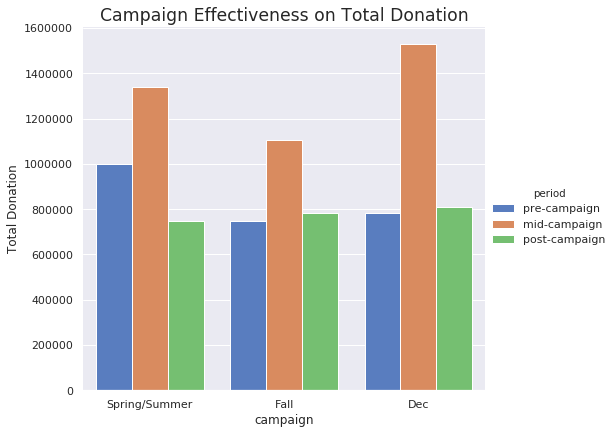

In [31]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set()

# Draw a nested barplot to show survival for class and sex
g = sns.catplot(x="campaign", y="Total Donation", hue="period", data=m1,
                height=6,aspect=1.2, kind="bar", palette="muted")
g.despine(left=True)
g.set_ylabels("Total Donation")
plt.title('Campaign Effectiveness on Total Donation', fontsize = 'x-large')

Text(0.5,1,'Campaign Effectiveness on the Number of Donors')

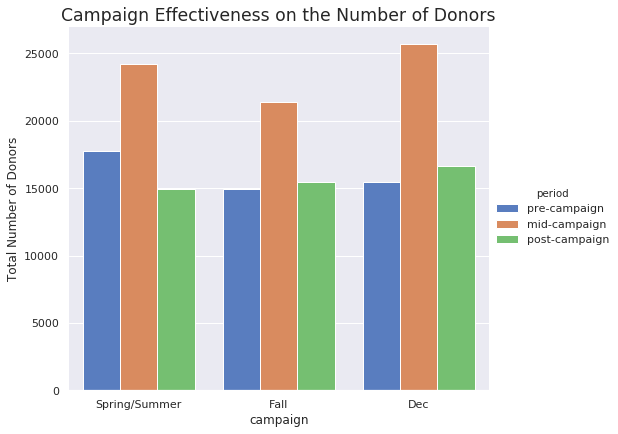

In [32]:
import seaborn as sns
import matplotlib.pyplot as plt
#sns.set(style="whitegrid")
sns.set()
# Draw a nested barplot to show survival for class and sex
g = sns.catplot(x="campaign", y="Total Number of Donors", hue="period", data=m1,
                height=6,aspect=1.2, kind="bar", palette="muted")
g.despine(left=True)
g.set_ylabels("Total Number of Donors")
plt.title('Campaign Effectiveness on the Number of Donors', fontsize = 'x-large')

Median values:
period         campaign     
mid-campaign   Dec              35.0
               Fall             35.0
               Spring/Summer    35.0
post-campaign  Dec              25.0
               Fall             25.0
               Spring/Summer    35.0
pre-campaign   Dec              25.0
               Fall             35.0
               Spring/Summer    40.0
Name: Donation/Person, dtype: float64


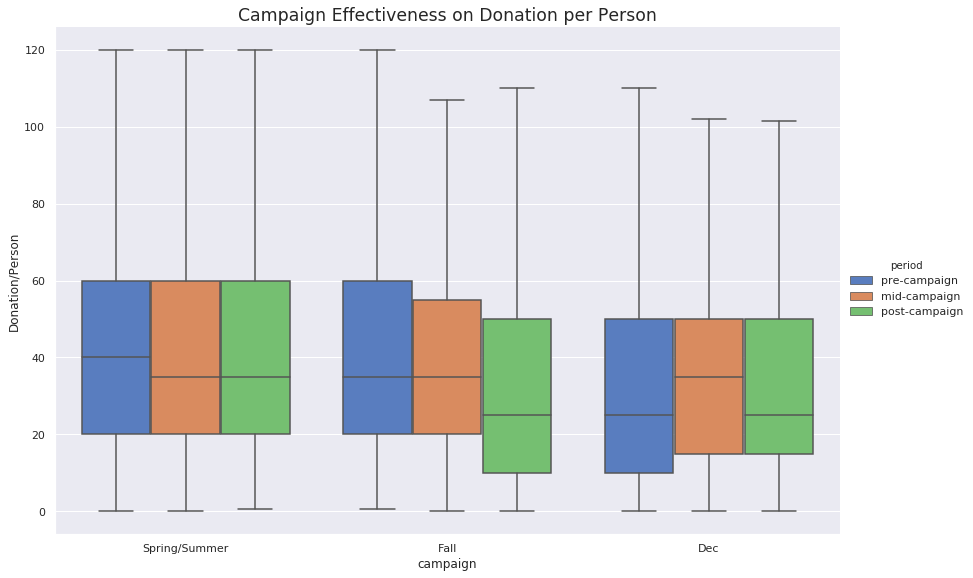

In [38]:
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
#sns.set(style="whitegrid")
sns.set()
sns.set(rc={'figure.figsize':(20,10)})
testPlot = sns.catplot(x='campaign', y='Donation/Person',
                       hue='period', data=combo_df, palette="muted",
                       showfliers=False,
                       kind='box'
                       ,height=8, aspect=1.5
                      )

plt.title('Campaign Effectiveness on Donation per Person', fontsize = 'x-large')

print("Median values:")
m1 = combo_df.groupby(['period', 'campaign'])['Donation/Person'].median()
mL1 = [str(np.round(s, 2)) for s in m1]
print(m1)


## 3.9 donation and subscription trend analysis
-  Aggregate subscription and donation data by month (page 12 - 13)
-  make multiple trend plots
- only consider donations now ( combine DON and SDN)

In [39]:
unique_years = subscription['ORD ENTR DT'].dt.year.unique()

counts_by_year = {'year_month':[],'DON':[]}
for single_year, single_month in itertools.product(unique_years,range(1,13)):

    subset_donation = donation[(donation['ORD ENTR DT'].dt.year == single_year) & \
                               (donation['ORD ENTR DT'].dt.month == single_month)]
    if (not subset_donation.empty):
        bc_donation = basic_counts(subset_donation)
        counts_by_year['DON'].append(int(bc_donation['nemails']))        
        counts_by_year['year_month'].append(datetime.datetime(single_year,single_month,1))
    
counts_by_year_df = pd.DataFrame.from_dict(counts_by_year)


events_by_year = {'year_month':[],'DON':[]}
for single_year, single_month in itertools.product(unique_years,range(1,13)):
    
    subset_donation = donation[(donation['ORD ENTR DT'].dt.year == single_year) & \
                               (donation['ORD ENTR DT'].dt.month == single_month)]
    if (not subset_donation.empty):
        events_by_year['DON'].append(subset_donation.shape[0])
        events_by_year['year_month'].append(datetime.datetime(single_year,single_month,1))
    
events_by_year_df = pd.DataFrame.from_dict(events_by_year)

amounts_by_year = {'year_month':[],'DON':[]}
for single_year, single_month in itertools.product(unique_years,range(1,13)):
    subset_donation = donation[(donation['ORD ENTR DT'].dt.year == single_year) & \
                               (donation['ORD ENTR DT'].dt.month == single_month)]
                                        
    if (not subset_donation.empty):
        bc_donation = basic_sum(subset_donation)
        amounts_by_year['DON'].append(bc_donation['sumamt'])
        
        amounts_by_year['year_month'].append(datetime.datetime(single_year,single_month,1))

amounts_by_year_df = pd.DataFrame.from_dict(amounts_by_year)

amounts_unit_by_year = {'year_month':[],'DON':[]}
for single_year, single_month in itertools.product(unique_years,range(1,13)):

    subset_donation = donation[(donation['ORD ENTR DT'].dt.year == single_year) & \
                               (donation['ORD ENTR DT'].dt.month == single_month)]
                                        
    if not subset_donation.empty:
        total_amounts = basic_sum(subset_donation)
        total_emails = basic_counts(subset_donation)

        amounts_unit_by_year['DON'].append(int(total_amounts['sumamt_by_pub'].loc['DON'])/int(total_emails['nemails_by_pub'].loc['DON']))     
        amounts_unit_by_year['year_month'].append(datetime.datetime(single_year,single_month,1))

amounts_unit_by_year_df = pd.DataFrame.from_dict(amounts_unit_by_year)

### plot to show the number of subscribers /donors change by month

In [40]:
def add_moving_avgs(dat,colname, N=5):

    mylist = dat[colname]
    cumsum, moving_aves = [0], []

    for i, x in enumerate(mylist, 1):
        cumsum.append(cumsum[i-1] + x)
        if i>=N:
            moving_ave = (cumsum[i] - cumsum[i-N])/N
            #can do stuff with moving_ave here
            moving_aves.append(moving_ave)
            
    
    temp = dat.copy()
    temp['moving_aves'] = [0]*int((N-1)/2) + moving_aves + [0]*int((N-1)/2)
    temp = temp[temp['moving_aves'] != 0]
    return(temp)

In [44]:
def make_solid_plot(x, y, df,
                    xlab, ylab, title, legends):
    
    # the function to make solid time series 
    # then add dashed 5 month average moving trend line
    import matplotlib.pyplot as plt

    plt.rcParams['figure.figsize'] = [18,5]

    plt.plot(x, y, data=df, marker='', markerfacecolor='green', 
             markersize=12, color='green', linewidth=4, linestyle = 'solid')

    # calculate trend with 5 month moving avgs
    df_moving_avgs = add_moving_avgs(dat = df, colname = y, N=5)
    
    plt.plot(x, 'moving_aves', data = df_moving_avgs,  marker='', color='orange', linewidth= 3, linestyle = 'dashed')
    plt.title("\n".join(wrap(title,50)),fontweight='bold', color = 'purple', fontsize = 'large')
    plt.xlabel(xlab,fontweight='bold', color = 'darkblue', fontsize = 'large')
    plt.ylabel(ylab,fontweight='bold', color = 'darkblue', fontsize = 'large')


    plt.axvline(x=datetime.datetime(2016,12,1), linestyle = '-',color='grey', linewidth=2)
    plt.axvline(x=datetime.datetime(2017,12,1), linestyle = '-',color='grey', linewidth=2)
    plt.axvline(x=datetime.datetime(2018,12,1), linestyle = '-',color='grey', linewidth=2)
    plt.legend(labels = legends)
    
    

### plot the number of donors change by month

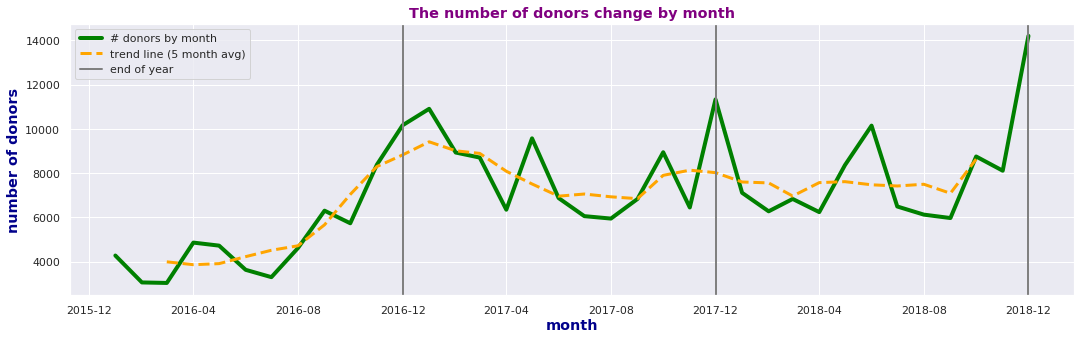

In [45]:
make_solid_plot(x = 'year_month', y = 'DON', df = counts_by_year_df,
                xlab = "month", ylab = "number of donors", title = "The number of donors change by month",
                legends = ['# donors by month','trend line (5 month avg)','end of year'])

### plot Total donation change by month

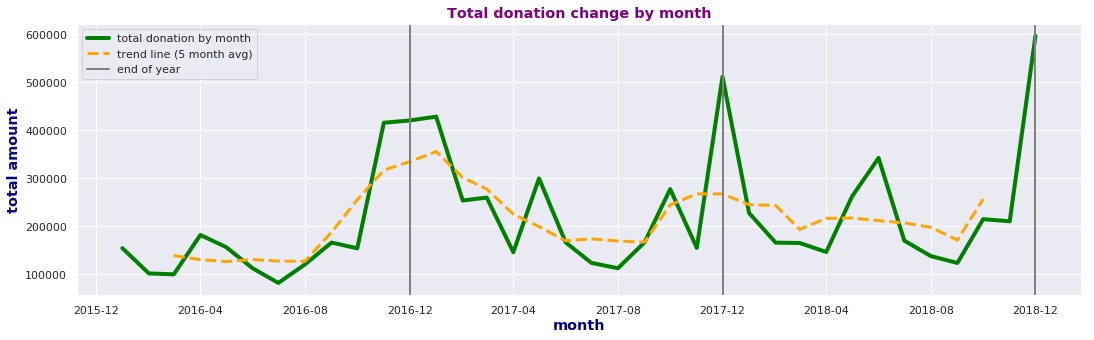

In [48]:
make_solid_plot(x = 'year_month', y = 'DON', df = amounts_by_year_df,
                xlab = "month", ylab = "total amount", title = "Total donation change by month",
                legends = ['total donation by month','trend line (5 month avg)','end of year']) 

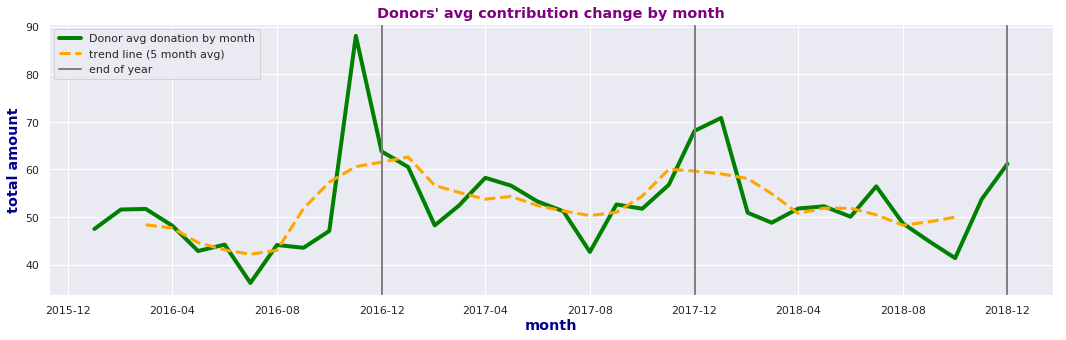

In [50]:
make_solid_plot(x = 'year_month', y = 'DON', df = amounts_unit_by_year_df,
                xlab = "month", ylab = "total amount", title = "Donors' avg contribution change by month",
                legends = ['Donor avg donation by month','trend line (5 month avg)','end of year'])

## 3.10 newsletter click trend analysis

### aggregate click data by month and make trend plot (Page 14 - 15)

In [52]:
def make_click_data_scatter_plot(x_colname, y_colname, df,
                                 xlab, ylab, title, legends):
    
    # the function to make solid time series 
    # then add dashed 5 month average moving trend line
    plt.rcParams['figure.figsize'] = [18,5]

    plt.plot_date( x= df[x_colname], 
                   y =df[y_colname],
                   color='green')

    # calculate trend with 5 month moving avgs
    df_moving_avgs= add_moving_avgs(dat = df, colname = y_colname,N=5)
    plt.plot( x_colname, 'moving_aves', data = df_moving_avgs,  marker='', color='orange', linewidth= 3, linestyle = 'solid')


    plt.title("\n".join(wrap(title,50)),fontweight='bold', color = 'purple', fontsize = 'large')
    plt.xlabel(xlab,fontweight='bold', color = 'darkblue', fontsize = 'large')
    plt.ylabel(ylab,fontweight='bold', color = 'darkblue', fontsize = 'large')

    plt.axvline(x=datetime.datetime(2017,12,1), linestyle = '-',color='grey', linewidth=2)
    plt.axvline(x=datetime.datetime(2018,12,1), linestyle = '-',color='grey', linewidth=2)
    plt.legend(labels = legends)
    

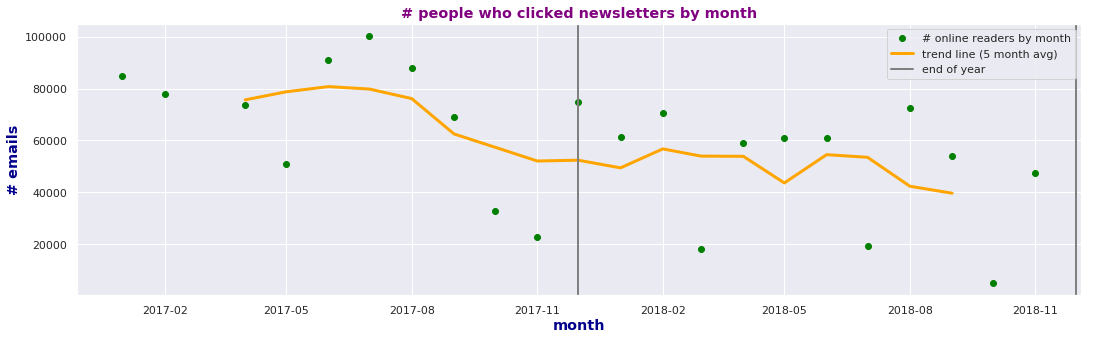

In [76]:
nemails_by_month = click_data.groupby('file_month').agg({'Email':'nunique'})
nemails_by_month = nemails_by_month.reset_index()

make_click_data_scatter_plot(x_colname = 'file_month', y_colname = 'Email', df = nemails_by_month,
                             xlab = "month", ylab = "# emails", title = "# people who clicked newsletters by month", 
                             legends = ['# online readers by month','trend line (5 month avg)','end of year'])

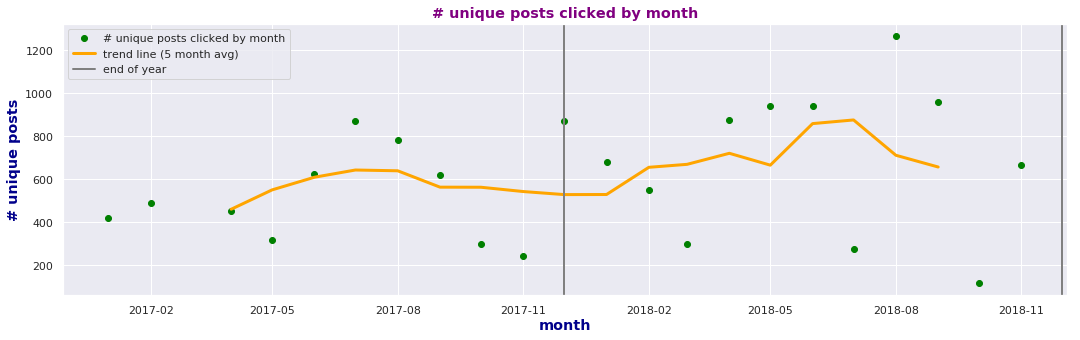

In [79]:
nurls_by_month = click_data.groupby('file_month').agg({'Url':'nunique'})

nurls_by_month = nurls_by_month.reset_index()

make_click_data_scatter_plot(x_colname = 'file_month', y_colname = 'Url', df = nurls_by_month,
                             xlab = "month", ylab = "# unique posts", title = "# unique posts clicked by month", 
                             legends = ['# unique posts clicked by month','trend line (5 month avg)','end of year'])

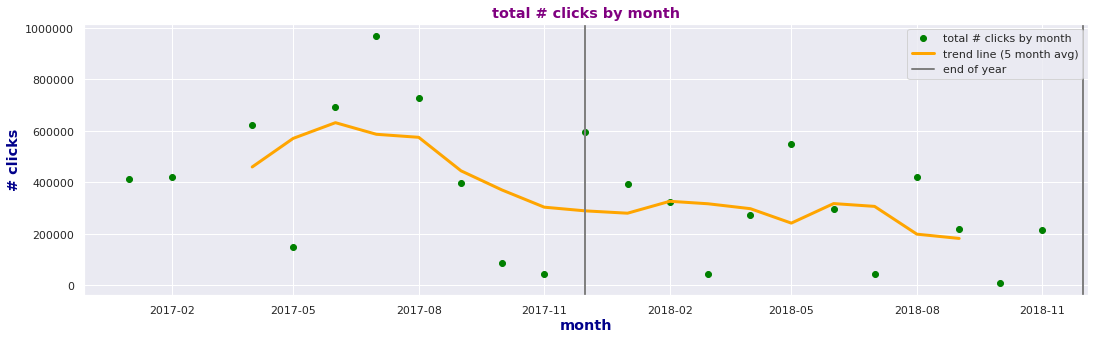

In [82]:
nclicks_by_month = click_data.groupby('file_month').agg({'Url':'count'})
nclicks_by_month = nclicks_by_month.reset_index()

make_click_data_scatter_plot(x_colname = 'file_month', y_colname = 'Url', df = nclicks_by_month,
                             xlab = "month", ylab = "# clicks", title = "total # clicks by month", 
                             legends = ['total # clicks by month','trend line (5 month avg)','end of year'])

### number of readers who first clicked posts ever by month, i.e # new readers by month (page 16)

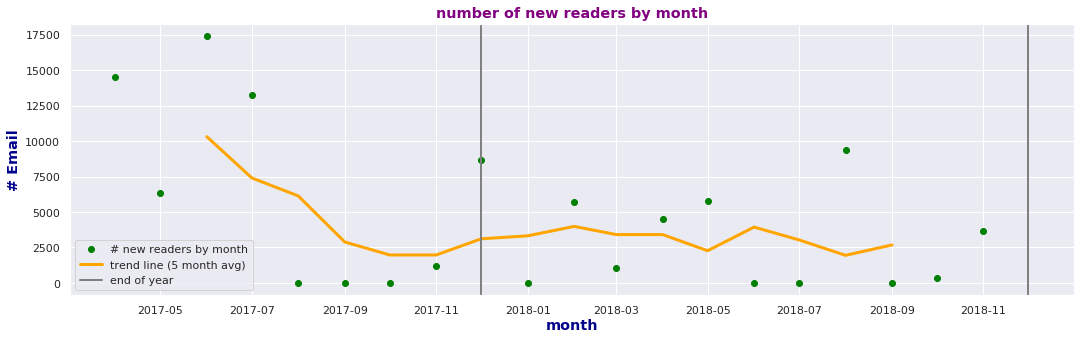

In [83]:
email_1st_click = click_data[(click_data.domain_type =='mojo_standard')].groupby('Email').agg({'file_month':'min'})
email_1st_click = email_1st_click.reset_index()
email_1st_click_bymonth = email_1st_click.groupby('file_month').agg({'Email':'count'})
email_1st_click_bymonth = email_1st_click_bymonth.reset_index()

placeholder = {'file_month':click_data.file_month.unique(), 'count':[0]*len(click_data.file_month.unique())}
placeholder_df = pd.DataFrame.from_dict(placeholder).merge(email_1st_click_bymonth, how = 'left', right_on = 'file_month', left_on ='file_month')
placeholder_df.fillna(0,inplace=True)
placeholder_df = placeholder_df.sort_values(by = 'file_month')
placeholder_df = placeholder_df[2:]

make_click_data_scatter_plot(x_colname = 'file_month', y_colname = 'Email', df = placeholder_df,
                             xlab = "month", ylab = "# Email", title = "number of new readers by month", 
                             legends = ['# new readers by month','trend line (5 month avg)','end of year'])

### avg click per person by month (page 18)

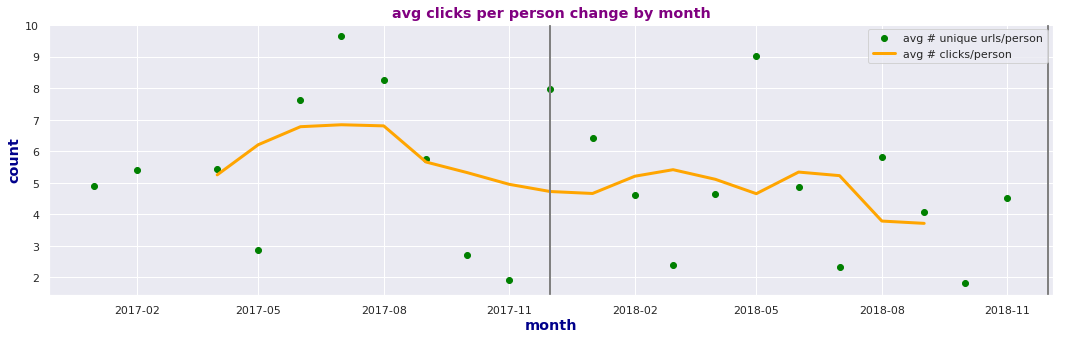

In [84]:
nclicks_by_personh = click_data.groupby(['file_month','Email']).agg({'Url':['count','nunique']})
nclicks_by_personh.columns = ["_".join(x) for x in nclicks_by_personh.columns.ravel()]
nclicks_by_personh = nclicks_by_personh.reset_index()
nclicks_by_person_by_month = nclicks_by_personh.groupby('file_month').agg({'Url_count':'mean','Url_nunique':'mean'})
nclicks_by_person_by_month = nclicks_by_person_by_month.reset_index()

make_click_data_scatter_plot(x_colname = 'file_month', y_colname = 'Url_count', df = nclicks_by_person_by_month,
                             xlab = "month", ylab = "count", title = "avg clicks per person change by month", 
                             legends = ['avg # unique urls/person','avg # clicks/person'])

In [85]:
click_spring_camp = click_data[click_data['file_month'].dt.month.isin([5,6])].groupby('Email').agg({'Url':'count'})
click_fall_camp = click_data[click_data['file_month'].dt.month.isin([9,10])].groupby('Email').agg({'Url':'count'})
click_dec_camp = click_data[click_data['file_month']==datetime.datetime(2017,12,1)].groupby('Email').agg({'Url':'count'})

click_pre_spring_camp = click_data[click_data['file_month'].dt.month.isin([3,4])].groupby('Email').agg({'Url':'count'})
click_pre_fall_camp = click_data[click_data['file_month'].dt.month.isin([7,8])].groupby('Email').agg({'Url':'count'})
click_pre_dec_camp = click_data[click_data['file_month']==datetime.datetime(2017,11,1)].groupby('Email').agg({'Url':'count'})

click_post_spring_camp = click_data[click_data['file_month'].dt.month.isin([7,8])].groupby('Email').agg({'Url':'count'})
click_post_fall_camp = click_data[click_data['file_month'].dt.month.isin([11])].groupby('Email').agg({'Url':'count'})
click_post_dec_camp = click_data[click_data['file_month']==datetime.datetime(2018,1,1)].groupby('Email').agg({'Url':'count'})



In [86]:
click_combo_dic = {'period':['pre-campaign']*(click_pre_spring_camp.shape[0] + click_pre_fall_camp.shape[0] + click_pre_dec_camp.shape[0]) + \
                      ['mid-campaign']*(click_spring_camp.shape[0] + click_fall_camp.shape[0] + click_dec_camp.shape[0]) + \
                      ['post-campaign']*(click_post_spring_camp.shape[0] + click_post_fall_camp.shape[0] + click_post_dec_camp.shape[0]),         
             '# clicks': pd.concat([click_pre_spring_camp,click_pre_fall_camp,click_pre_dec_camp,
                                           click_spring_camp,click_fall_camp,click_dec_camp,
                                           click_post_spring_camp,click_post_fall_camp,click_post_dec_camp])['Url'],
             'campaign':['Spring/Summer']*click_pre_spring_camp.shape[0] + ['Fall']*click_pre_fall_camp.shape[0] + ['Dec']*click_pre_dec_camp.shape[0] + \
                        ['Spring/Summer']*click_spring_camp.shape[0] + ['Fall']*click_fall_camp.shape[0] + ['Dec']*click_dec_camp.shape[0] + \
                        ['Spring/Summer']*click_post_spring_camp.shape[0] + ['Fall']*click_post_fall_camp.shape[0] + ['Dec']*click_post_dec_camp.shape[0]
            }
click_combo_df = pd.DataFrame.from_dict(click_combo_dic)

In [87]:
m1 = click_combo_df.groupby(['period', 'campaign']).agg({'# clicks':'sum'})
m1 = m1.reset_index()
m1.rename(columns = {'# clicks':'Total Clicks'}, inplace=True)
m1 = pd.concat([m1[m1.period == 'pre-campaign'],m1[m1.period == 'mid-campaign'],m1[m1.period == 'post-campaign']])
m1 = m1.sort_values('campaign', ascending = False)

Text(0.5,1,'Campaign Effectiveness on Total Newsletter Clicks')

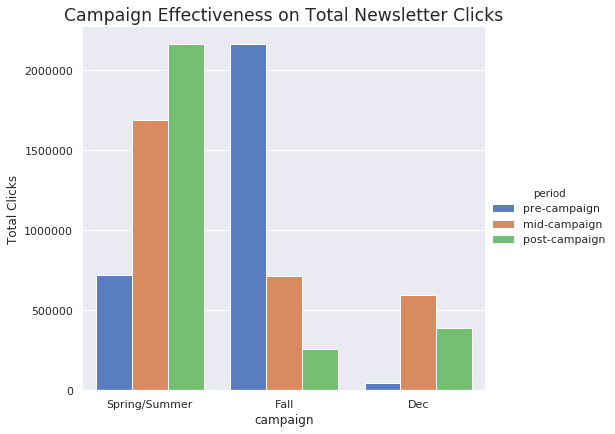

In [88]:
import seaborn as sns
sns.set()
# Draw a nested barplot to show survival for class and sex
g = sns.catplot(x="campaign", y="Total Clicks", hue="period", data=m1,
                height=6,aspect=1.2, kind="bar", palette="muted")
g.despine(left=True)
g.set_ylabels("Total Clicks")
plt.title('Campaign Effectiveness on Total Newsletter Clicks', fontsize = 'x-large')


Median values:
period         campaign     
mid-campaign   Dec              3
               Fall             3
               Spring/Summer    6
post-campaign  Dec              3
               Fall             2
               Spring/Summer    6
pre-campaign   Dec              1
               Fall             6
               Spring/Summer    3
Name: # clicks, dtype: int64


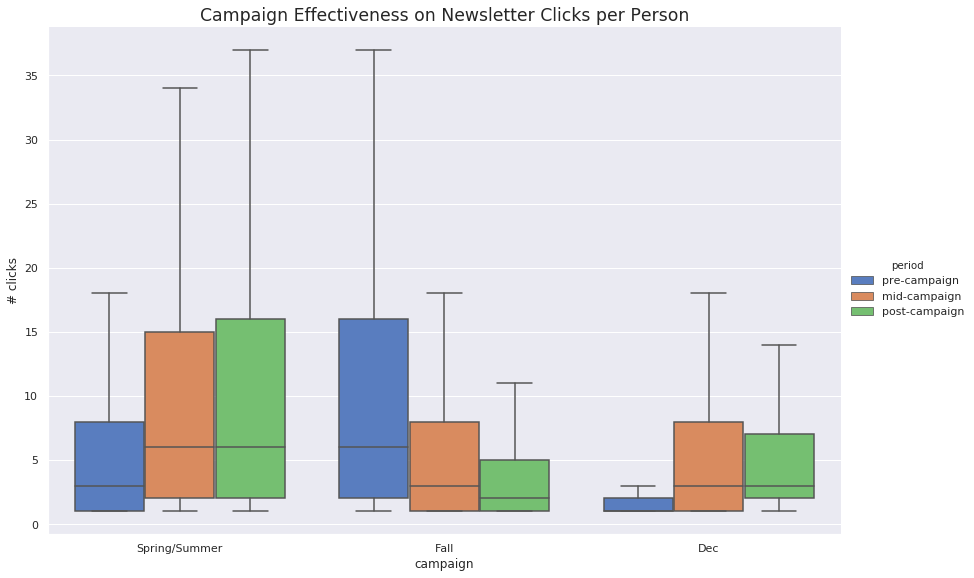

In [90]:
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
#sns.set(style="whitegrid")

testPlot = sns.catplot(x='campaign', y='# clicks',
                       hue='period', data=click_combo_df, palette="muted",
                       showfliers=False,
                       kind='box',height=8, aspect=1.5)

plt.title('Campaign Effectiveness on Newsletter Clicks per Person', fontsize = 'x-large')

print("Median values:")
print(click_combo_df.groupby(['period', 'campaign'])['# clicks'].median())


## 3.11 Survival Anlysis of newsletter engagement
### Survival Analysis of how many months people clicked newsletters (page 19)
- only consider readers who started from 2017 and their 12-month activities

In [32]:
import datetime
import calendar

def add_months(sourcedate,months):
    month = sourcedate.month - 1 + months
    year = sourcedate.year + month // 12
    month = month % 12 + 1
    day = min(sourcedate.day,calendar.monthrange(year,month)[1])
    return datetime.date(year,month,day)

def diff_month(d1, d2):
    return (d1.year - d2.year) * 12 + d1.month - d2.month

In [33]:
click_data_min = click_data.groupby(['Email']).agg({'file_month':'min'})
click_data_min = click_data_min.reset_index()
clicked_2017 = click_data_min[click_data_min['file_month'] < datetime.datetime(2017,12,1)]['Email']

filtered_click_data = click_data[click_data['Email'].isin(clicked_2017)]


filtered_click_data2 = filtered_click_data.merge(click_data_min, left_on = 'Email', right_on = 'Email')
filtered_click_data2.rename(columns = {'file_month_x':'file_month','file_month_y':'first_month'},inplace=True)

In [34]:
filtered_click_data2['latest_month'] = [ add_months(x,11) for x in filtered_click_data2['first_month']]

filtered_click_data2['latest_month'] = pd.to_datetime(filtered_click_data2['latest_month'])

filtered_click_data2 = filtered_click_data2[filtered_click_data2['file_month'] <= filtered_click_data2['latest_month']]


In [35]:
filtered_click_data2_agg = filtered_click_data2.groupby(['Email']).agg({'file_month':['nunique','max'],
                                                                        'latest_month':'max',
                                                                        'first_month':'max'})
filtered_click_data2_agg.columns = ["_".join(x) for x in filtered_click_data2_agg.columns.ravel()]
filtered_click_data2_agg = filtered_click_data2_agg.reset_index()

filtered_click_data2_agg['month_range'] = [diff_month(x,y)+1 for x, y in zip(filtered_click_data2_agg['file_month_max'],filtered_click_data2_agg['first_month_max'])]
filtered_click_data2_agg['is_censored'] = [int(x) for x in (filtered_click_data2_agg['file_month_max'] == filtered_click_data2_agg['latest_month_max'])]

In [53]:
print('{}% emails were censored cuz they are active users'.format(round(100*filtered_click_data2_agg.is_censored.mean(),2)))
print(filtered_click_data2_agg['month_range'].describe())

34.86% emails were censored cuz they are active users
count    161686.000000
mean     7.321036     
std      4.485225     
min      1.000000     
25%      2.000000     
50%      8.000000     
75%      12.000000    
max      12.000000    
Name: month_range, dtype: float64


### Survival rate for each month's new readers (page 17)
- used to explain why click rate is going down

Text(0.5,1,"Survival rate for each month's new readers")

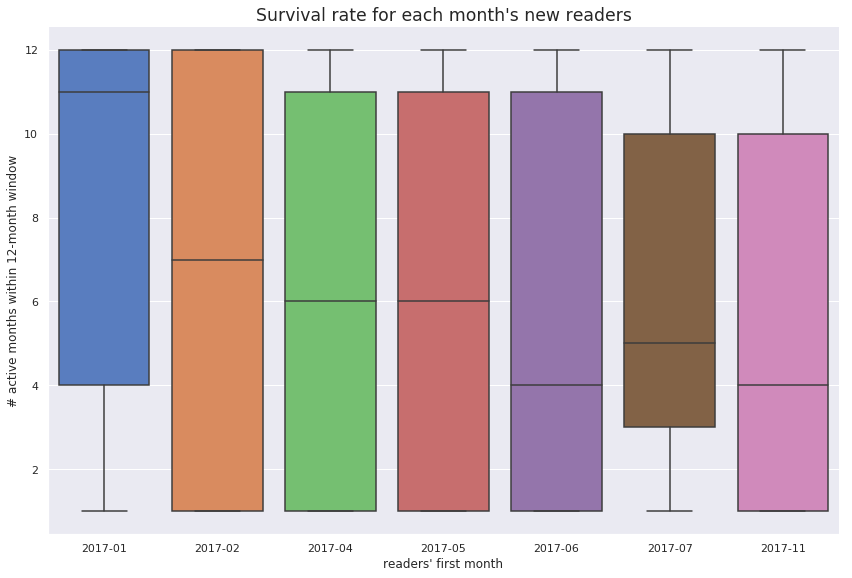

In [51]:
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import datetime as dt
#sns.set(style="whitegrid")

filtered_click_data2_agg['first_month'] = filtered_click_data2_agg['first_month_max'].apply(lambda x: dt.datetime.strftime(x, '%Y-%m'))
filtered_click_data2_agg = filtered_click_data2_agg.sort_values('first_month')
g = sns.catplot(x='first_month', y='month_range',
                        data=filtered_click_data2_agg, palette="muted",
                       showfliers=False,
                       kind='box',height=8, aspect=1.5)
g.set_ylabels("# active months within 12-month window")
g.set_xlabels("readers' first month")

plt.title("Survival rate for each month's new readers", fontsize = 'x-large')

Text(0,0.5,'probability')

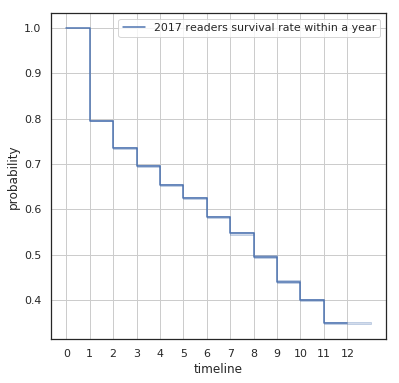

In [61]:
from lifelines import KaplanMeierFitter
import matplotlib.pyplot as plt
sns.set(style="white")
plt.rcParams['figure.figsize'] = [6,6]

durations = filtered_click_data2_agg['month_range']
event_observed = 1-filtered_click_data2_agg['is_censored']

## create a kmf object
kmf = KaplanMeierFitter() 

## Fit the data into the model
kmf.fit(durations, event_observed,label='2017 readers survival rate within a year')

a1 = kmf.plot(ci_show=True)
a1.grid()
a1.set_xticks(range(0,max(filtered_click_data2_agg['month_range'])+1))
a1.set_ylabel("probability")


In [60]:
def intersection(lst1, lst2): 
    lst3 = [value for value in lst1 if value in lst2] 
    return lst3 

def leftjoin(lst1, lst2): 
    lst3 = [value for value in lst1 if value not in lst2] 
    return lst3 

## Example Data 
donors = donation[(donation['ORD ENTR DT'] > datetime.datetime(2017,1,1)) & (donation['ORD ENTR DT'] < datetime.datetime(2018,12,31))]['EMAIL'].unique().tolist()

subscribers = subscription[(subscription['ORD ENTR DT'] > datetime.datetime(2017,1,1)) & (subscription['ORD ENTR DT'] < datetime.datetime(2018,12,31))]['EMAIL'].unique().tolist()

don_y_sub_y = intersection(donors,subscribers)
don_y_sub_n = leftjoin(donors,subscribers)
don_n_sub_y = leftjoin(subscribers,donors)

#### donors ####
52.13% emails were censored cuz they are active users
count    14183.000000
mean     8.568427    
std      4.418182    
min      1.000000    
25%      4.000000    
50%      12.000000   
75%      12.000000   
max      12.000000   
Name: month_range, dtype: float64
33.2% emails were censored cuz they are active users
count    147503.000000
mean     7.201094     
std      4.473340     
min      1.000000     
25%      2.000000     
50%      8.000000     
75%      12.000000    
max      12.000000    
Name: month_range, dtype: float64
#### subscribers ####
40.68% emails were censored cuz they are active users
count    11525.000000
mean     7.700043    
std      4.541204    
min      1.000000    
25%      2.000000    
50%      9.000000    
75%      12.000000   
max      12.000000   
Name: month_range, dtype: float64
34.42% emails were censored cuz they are active users
count    150161.000000
mean     0.655836     
std      0.475096     
min      0.000000     
25%      0.00000

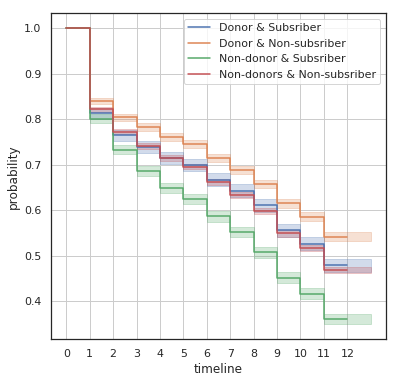

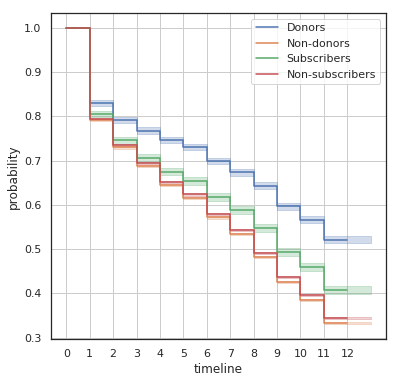

In [62]:
print("#### donors ####")
durations_donors = filtered_click_data2_agg[filtered_click_data2_agg['Email'].isin(donors)]['month_range']
event_observed_donors = 1-filtered_click_data2_agg[filtered_click_data2_agg['Email'].isin(donors)]['is_censored']
print('{}% emails were censored cuz they are active users'.format(round(100*(1-event_observed_donors).mean(),2)))
print(durations_donors.describe())
 

durations_nondonors = filtered_click_data2_agg[~filtered_click_data2_agg['Email'].isin(donors)]['month_range']
event_observed_nondonors = 1-filtered_click_data2_agg[~filtered_click_data2_agg['Email'].isin(donors)]['is_censored']
print('{}% emails were censored cuz they are active users'.format(round(100*(1-event_observed_nondonors).mean(),2)))
print(durations_nondonors.describe())

print("#### subscribers ####")
durations_subscribers = filtered_click_data2_agg[filtered_click_data2_agg['Email'].isin(subscribers)]['month_range']
event_observed_subscribers = 1-filtered_click_data2_agg[filtered_click_data2_agg['Email'].isin(subscribers)]['is_censored']
print('{}% emails were censored cuz they are active users'.format(round(100*(1-event_observed_subscribers).mean(),2)))
print(durations_subscribers.describe())

durations_nonsubscribers = filtered_click_data2_agg[~filtered_click_data2_agg['Email'].isin(subscribers)]['month_range']
event_observed_nonsubscribers = 1-filtered_click_data2_agg[~filtered_click_data2_agg['Email'].isin(subscribers)]['is_censored']
print('{}% emails were censored cuz they are active users'.format(round(100*(1-event_observed_nonsubscribers).mean(),2)))
print(event_observed_nonsubscribers.describe())


print("#### donors & subscribers ####")
durations_don_y_sub_y = filtered_click_data2_agg[filtered_click_data2_agg['Email'].isin(don_y_sub_y)]['month_range']
event_observed_don_y_sub_y = 1-filtered_click_data2_agg[filtered_click_data2_agg['Email'].isin(don_y_sub_y)]['is_censored']
print('{}% emails were censored cuz they are active users'.format(round(100*(1-event_observed_don_y_sub_y).mean(),2)))
print(durations_don_y_sub_y.describe())

print("#### donors & non-subscribers ####")
durations_don_y_sub_n = filtered_click_data2_agg[filtered_click_data2_agg['Email'].isin(don_y_sub_n)]['month_range']
event_observed_don_y_sub_n = 1-filtered_click_data2_agg[filtered_click_data2_agg['Email'].isin(don_y_sub_n)]['is_censored']
print('{}% emails were censored cuz they are active users'.format(round(100*(1-event_observed_don_y_sub_n).mean(),2)))
print(durations_don_y_sub_n.describe())

print("#### non-donors & subscribers ####")
durations_don_n_sub_y = filtered_click_data2_agg[filtered_click_data2_agg['Email'].isin(don_n_sub_y)]['month_range']
event_observed_don_n_sub_y = 1-filtered_click_data2_agg[filtered_click_data2_agg['Email'].isin(don_n_sub_y)]['is_censored']
print('{}% emails were censored cuz they are active users'.format(round(100*(1-event_observed_don_n_sub_y).mean(),2)))
print(durations_don_n_sub_y.describe())

print("#### non-donors & non subscribers ####")
durations_don_n_sub_n = filtered_click_data2_agg[filtered_click_data2_agg['Email'].isin(don_n_sub_y + don_y_sub_n + don_y_sub_y)]['month_range']
event_observed_don_n_sub_n = 1-filtered_click_data2_agg[filtered_click_data2_agg['Email'].isin(don_n_sub_y + don_y_sub_n + don_y_sub_y)]['is_censored']
print('{}% emails were censored cuz they are active users'.format(round(100*(1-event_observed_don_n_sub_n).mean(),2)))
print(durations_don_n_sub_n.describe())



## create a kmf object
from lifelines import KaplanMeierFitter
kmf1 = KaplanMeierFitter() 
kmf1.fit(durations_don_y_sub_y, event_observed_don_y_sub_y, label='Donor & Subsriber')
a1 = kmf1.plot()
a1.set_xticks(range(0,max(filtered_click_data2_agg['month_range'])+1))
a1.set_ylabel("probability")

## fit the model for 2nd cohort
kmf1.fit(durations_don_y_sub_n, event_observed_don_y_sub_n, label='Donor & Non-subsriber')
kmf1.plot(ax=a1)

## fit the model for 3nd cohort
kmf1.fit(durations_don_n_sub_y, event_observed_don_n_sub_y, label='Non-donor & Subsriber')
kmf1.plot(ax=a1)

## fit the model for 4nd cohort
kmf1.fit(durations_don_n_sub_n, event_observed_don_n_sub_n, label='Non-donors & Non-subsriber')
kmf1.plot(ax=a1)

a1.grid()



from lifelines import KaplanMeierFitter
kmf2 = KaplanMeierFitter() 
kmf2.fit(durations_donors, event_observed_donors, label='Donors')
a2 = kmf2.plot()
a2.set_xticks(range(0,max(filtered_click_data2_agg['month_range'])+1))
a2.set_ylabel("probability")

## fit the model for 2nd cohort
kmf2.fit(durations_nondonors, event_observed_nondonors, label='Non-donors')
kmf2.plot(ax=a2)

## fit the model for 3nd cohort
kmf2.fit(durations_subscribers, event_observed_subscribers, label='Subscribers')
kmf2.plot(ax=a2)

## fit the model for 4nd cohort
kmf2.fit(durations_nonsubscribers, event_observed_nonsubscribers, label='Non-subscribers')
kmf2.plot(ax=a2)

a2.grid()

# 4 Insight Group - User Behavior Comparison

## 4.1 What do our print subscribers engage in vs our online readers in the newsletters? (page 21)

The newsletter click data ranges from 2018/09/19 to 2018/10/30
The magazine subscription data ranges from 2017-10-01 to 2018-11-09

Limit magazine subscribers to 2017/09/20 - 2018/10/30 to get the overlap between newsletter subscribes and magazine subscribes

In [53]:
nclicks_by_users = click_data.groupby('Email').agg({'Url': pd.Series.nunique,'topic':pd.Series.nunique})
nclicks_by_users = nclicks_by_users.reset_index()

nclicks_by_topics = reshape_data_to_wide(click_data,
                                         row = 'Email', 
                                         col = 'topic', 
                                         element = 'Url',
                                         cal = 'sum')
nclicks_by_topics = nclicks_by_topics.reset_index()
nclicks_by_topics = nclicks_by_topics.rename(columns = {'':'NA'})

nclicks_by_various_topics = pd.read_pickle('nclicks_by_various_topics')
nclicks_by_modeling_topics= pd.read_pickle('nclicks_by_modeling_topics')

In [54]:
min_date = datetime.date(2016, 1, 1)
min_date2 = datetime.date(2017, 1, 1)
max_date = datetime.date(2018, 11, 30)

# get all the emails who subscribed the magazine within a year of the click data but before the end date of the click data
mag_sub = subscription[(subscription['ORD ENTR DT'] > min_date) & (subscription['ORD ENTR DT'] < max_date)]['EMAIL'].unique().tolist()
# get all the emails who subscribed the magazine during the newsletter campaign
recent_mag_sub = subscription[(subscription['ORD ENTR DT'] > min_date2) & (subscription['ORD ENTR DT'] < max_date)]['EMAIL'].unique().tolist()
# get all the emails who subscribed the news letter
news_sub = click_data['Email'].unique().tolist()

mag_news_sub_all = combine_dat_sets(nclicks_by_various_topics, nclicks_by_users, 'Email','Email', join_method = 'left')
mag_news_sub_all['MJM'] = mag_news_sub_all['Email'].isin(mag_sub)

online_reader_groups=OrderedDict()
online_reader_groups['magazine subscribers']=mag_news_sub_all[mag_news_sub_all['MJM'] == True]
online_reader_groups['non-magazine subscribers']=mag_news_sub_all[ mag_news_sub_all['MJM'] == False]
online_reader_groups['recent magazine subscribers']=mag_news_sub_all[(mag_news_sub_all['MJM'] == True) & (mag_news_sub_all['Email'].isin(recent_mag_sub))]

### a. how many online readers have subscribed the magazine? (page 21)

In [55]:
print('out of {} clicked the newsletter, {} have subscribed magazine within a year ({}%)'.format(
    mag_news_sub_all.shape[0], 
    sum(mag_news_sub_all['MJM']), 
    round(sum(mag_news_sub_all['MJM'])/mag_news_sub_all.shape[0]*100,2)
 ))


out of 200795 clicked the newsletter, 17044 have subscribed magazine within a year (8.49%)


### b. what's the click rate difference between online reasers who subcribed the magazines within a year,  who subscribed the magazines during the newsletter campaign and who didn't subcribe the magazines? (page 21)

In [56]:
grps = ['magazine subscribers','recent magazine subscribers','non-magazine subscribers']

online_reader_groups_click = {'group':[],'num_clicks': []}

for g in grps:
    online_reader_groups_click['group'].extend([g]*len(online_reader_groups[g]))
    online_reader_groups_click['num_clicks'].extend(online_reader_groups[g]['Url'])
online_reader_groups_click_df = pd.DataFrame.from_dict(online_reader_groups_click)

In [132]:
def plot_group_boxplot(x_colname, y_colname, df,
                      xlab, ylab,
                      xticklab, yticklab,
                      title,
                      orient="v"):
    import seaborn as sns
    import pandas as pd
    import numpy as np
    import matplotlib.pylab as plt
    import datetime as dt
    sns.set()

    g = sns.catplot(x=x_colname, y=y_colname,
                    data=df, palette="muted",
                    showfliers=False,
                    kind='box',height=6, aspect=1.5, orient = orient)
    g.set_ylabels(ylab,fontsize = 'x-large',fontweight = 'bold')
    g.set_xlabels(xlab, fontsize = 'x-large',fontweight = 'bold')
    
    if orient == 'v':
        if max([len(s) for s in xticklab]) > 30:
            rotation_degree = 20
        else:
            rotation_degree = 0
    else:
        rotation_degree = 0
        
    if len(xticklab) != 0:
        # use default values if tick labels are not given
        g.set_xticklabels(xticklab, 
                       rotation=rotation_degree,fontweight = 'bold',fontsize = 'large', color = '#34495e')
    else:
        g.set_xticklabels(rotation=rotation_degree,fontweight = 'bold',fontsize = 'large', color = '#34495e')
        
    if len(yticklab) != 0:
        g.set_yticklabels(yticklab, 
                           rotation=0,fontweight = 'bold',fontsize = 'large', color = '#34495e')
    else:
        # use default values if tick labels are not given
        g.set_yticklabels(rotation=0,fontweight = 'bold',fontsize = 'large', color = '#34495e')
    plt.title(title, fontsize = 'x-large',fontweight = 'bold')

    if orient == 'v':
        print("Median values:")
        print(df.groupby([x_colname])[y_colname].median())
    else:
        print("Median values:")
        print(df.groupby([y_colname])[x_colname].median())
 


Median values:
group
magazine subscribers           7.0
non-magazine subscribers       5.0
recent magazine subscribers    7.0
Name: num_clicks, dtype: float64


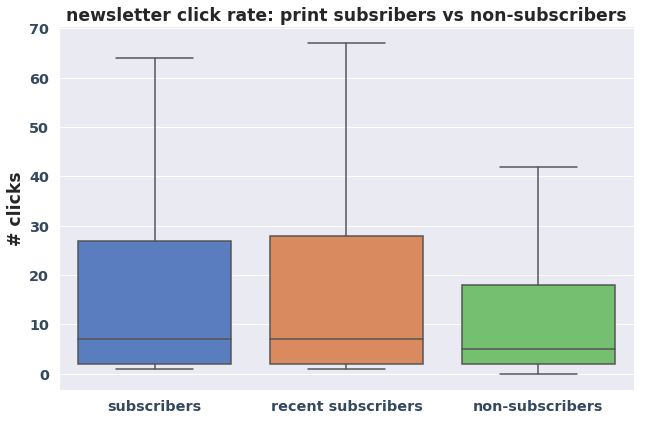

In [91]:
plot_group_boxplot(x_colname = 'group', y_colname = 'num_clicks', df = online_reader_groups_click_df,
                      xlab = "", ylab = "# clicks",
                      xticklab = ['subscribers','recent subscribers','non-subscribers'], 
                      yticklab = range(-10,int(max(online_reader_groups_click_df['num_clicks'])),10),
                      title = "newsletter click rate: print subsribers vs non-subscribers")

In [92]:
online_reader_groups_click_summary = []

for grpname, dat in online_reader_groups.items():
    
    online_reader_groups_click_summary.append(check_click_distribution(df =dat, groupname =grpname))
    
print("compare # urls clicked by each donor group ")    
display(pd.concat(online_reader_groups_click_summary, axis=1))

online_reader_groups_topics_summary = []

for grpname, dat in online_reader_groups.items():
    
    online_reader_groups_topics_summary.append(check_topics_distribution(df =dat, groupname =grpname))
    
print("compare # topics clicked by each donor group ")    
display(pd.concat(online_reader_groups_topics_summary, axis=1))

compare # urls clicked by each donor group 


,magazine subscribers,non-magazine subscribers,recent magazine subscribers
count,17044.00,183750.00,14594.00
mean,28.24,21.15,28.86
std,61.11,48.37,62.41
min,1.00,1.00,1.00
25%,2.00,2.00,2.00
50%,7.00,5.00,7.00
75%,27.00,18.00,28.00
max,1245.00,1381.00,1245.00


compare # topics clicked by each donor group 


,magazine subscribers,non-magazine subscribers,recent magazine subscribers
count,17044.00,183750.00,14594.00
mean,3.23,3.05,3.25
std,2.16,1.96,2.15
min,1.00,1.00,1.00
25%,1.00,1.00,1.00
50%,3.00,3.00,3.00
75%,5.00,4.00,5.00
max,12.00,17.00,12.00


### c. what's the difference in the interested topics between online reasers who subcribed the magazines within a year, who subscribed the magazines during the newsletter campaign and who didn't subcribe the magazines?

### heatmap subscriber vs non-subscriber using MOJO topics (page 22)

In [147]:
def plot_topic_heatmap(df, xlab, ylab, xticklab, yticklab, title, fig_width = 14, fig_height = 8):
    import seaborn as sns; sns.set()
    sns.set(rc={'figure.figsize':(fig_width,fig_height)})
    g = sns.heatmap(df, 
                 annot=True,
                 annot_kws = {'size':20},
                 cmap="PiYG",
                 center = 0,
                 linewidths=.5)
    g.set_ylabel(ylab,fontsize = 'x-large',fontweight = 'bold')
    g.set_xlabel(xlab, fontsize = 'x-large',fontweight = 'bold')
    
    if max([len(s) for s in xticklab]) > 25 :
        rotation_degree = 20
    else:
        rotation_degree = 0
    
    g.set_xticklabels(xticklab, 
                       rotation=rotation_degree,fontweight = 'bold',fontsize = 'large', color = '#34495e')
    g.set_yticklabels(yticklab, 
                       rotation=0,fontweight = 'bold',fontsize = 'large', color = '#34495e')
    plt.title(title, fontsize = 'x-large',fontweight = 'bold')

compare magazine subscribers, recent magazine subscribers and non subscribers of the topics they clicked
all the numbers are the percentage of urls containing the certain topics
               magazine subscribers  non-magazine subscribers  \
about          0.24                  0.15                       
crime-justice  0.78                  0.79                       
environment    19.11                 19.97                      
food           4.91                  5.26                       
kevin-drum     11.18                 11.23                      
media          4.81                  4.32                       
mixed-media    0.41                  0.59                       
politics       57.85                 56.94                      

               recent magazine subscribers  
about          0.25                         
crime-justice  0.79                         
environment    19.04                        
food           4.94                         
kevin-drum 

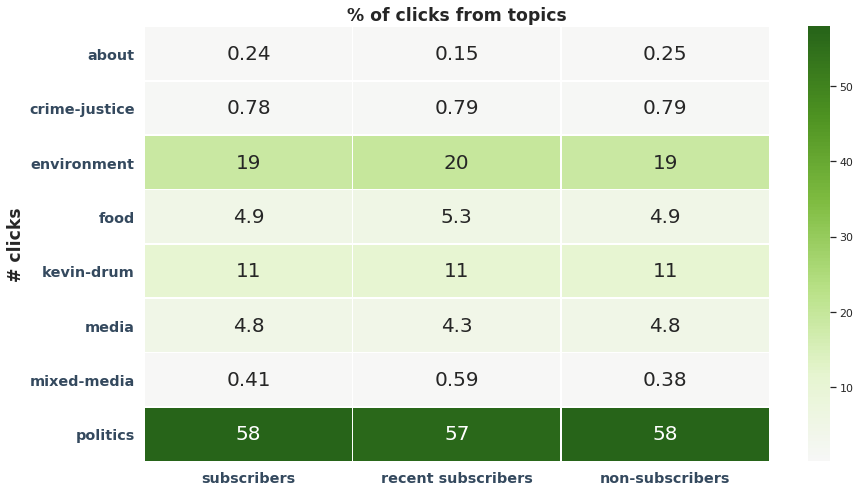

In [60]:
# compare topic click rate
topics = ['about','crime-justice', 'environment', 'food', 'kevin-drum',
       'media', 'mixed-media','politics']
comparison_groups = ['magazine subscribers',
                     'non-magazine subscribers',
                     'recent magazine subscribers'
                    ]
combo = pd.concat([sub_df_colsum(df = online_reader_groups[k],cols = topics, name = k) for k in comparison_groups],axis=1)

# convert to click percentage
for g in comparison_groups:
      combo[g] = round(combo[g]/sum(online_reader_groups[g]['All'])*100,2) 
     
print('compare magazine subscribers, recent magazine subscribers and non subscribers of the topics they clicked')
print('all the numbers are the percentage of urls containing the certain topics')
print(combo)

plot_topic_heatmap(df = combo, xlab = "", ylab ="# clicks", 
                   xticklab = ['subscribers','recent subscribers','non-subscribers'], 
                   yticklab = [x.replace('LDA_','') for x in combo.index], 
                   title = "% of clicks from topics", 
                   fig_width = 14, fig_height = 8)

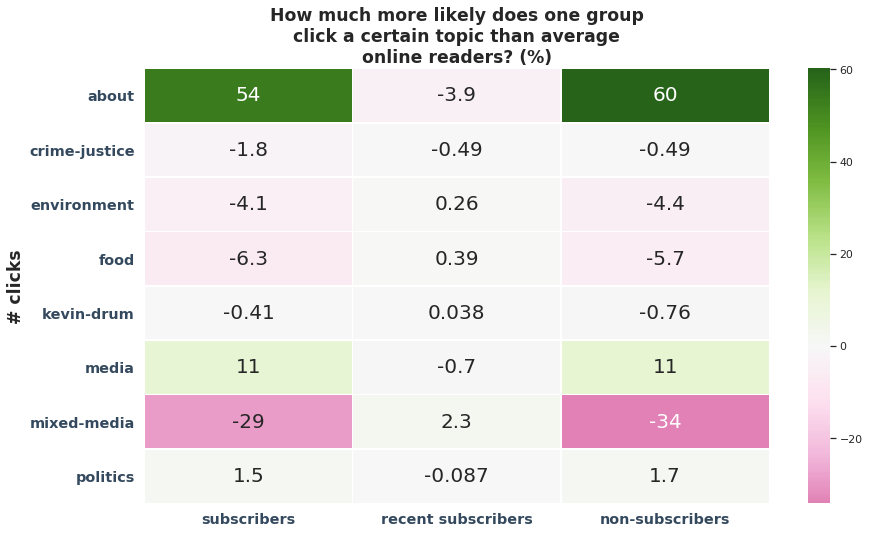

In [61]:
overal_dist =sub_df_colsum(df = mag_news_sub_all,cols = topics, name = 'all readers')/sum(mag_news_sub_all['All'])
combo_index = combo.copy()

for g in comparison_groups:
      combo_index[g] = 100*(combo[g]/100/overal_dist - 1)

        
plot_topic_heatmap(df = combo_index, xlab = "", ylab ="# clicks", 
                   xticklab = ['subscribers','recent subscribers','non-subscribers'], 
                   yticklab = combo.index, 
                   title = "\n".join(wrap('How much more likely does one group click a certain topic than average online readers? (%)',40)), 
                   fig_width = 14, fig_height = 8)        
        


### define NMF and LDA topics for heatmaps

In [62]:
nmf_topics = pd.read_csv(nmf_feature_filename,encoding = "ISO-8859-1").add_prefix('NMF_').columns[1:]
lda_topics = pd.read_csv(lda_feature_filename,encoding = "ISO-8859-1").add_prefix('LDA_').columns[1:]


### heatmap LDA topic subscribers vs non-subscribers (page 24)

compare magazine subscribers, recent magazine subscribers and non subscribers of the topics they clicked
all the numbers are the percentage of urls containing the certain topics


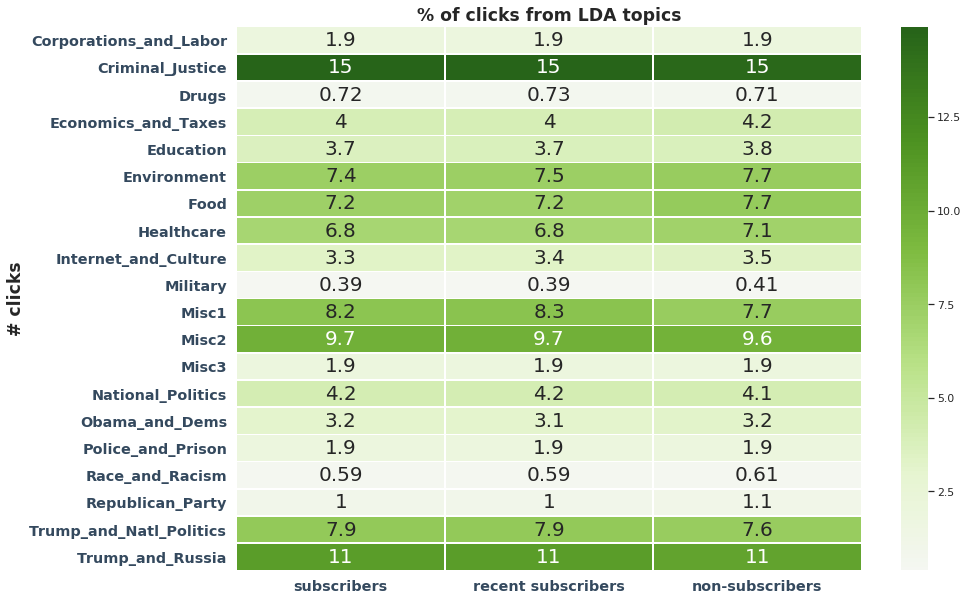

In [63]:
# compare topic click rate

comparison_groups = ['magazine subscribers',
                     'non-magazine subscribers',
                     'recent magazine subscribers'
                    ]
combo = pd.concat([sub_df_colsum(df = online_reader_groups[k],cols = lda_topics, name = k) for k in comparison_groups],axis=1)

# convert to click percentage

for g in comparison_groups:
      combo[g] = round(combo[g]/sum(online_reader_groups[g][lda_topics].sum(axis =0))*100,2) 
     
print('compare magazine subscribers, recent magazine subscribers and non subscribers of the topics they clicked')
print('all the numbers are the percentage of urls containing the certain topics')
combo = combo.sort_index()
combo = combo[['magazine subscribers','recent magazine subscribers','non-magazine subscribers']]
combo

plot_topic_heatmap(df = combo, xlab = "", ylab ="# clicks", 
                   xticklab = ['subscribers','recent subscribers','non-subscribers'], 
                   yticklab = [x.replace('LDA_','') for x in combo.index], 
                   title = "% of clicks from LDA topics", 
                   fig_width = 14, fig_height = 10)  

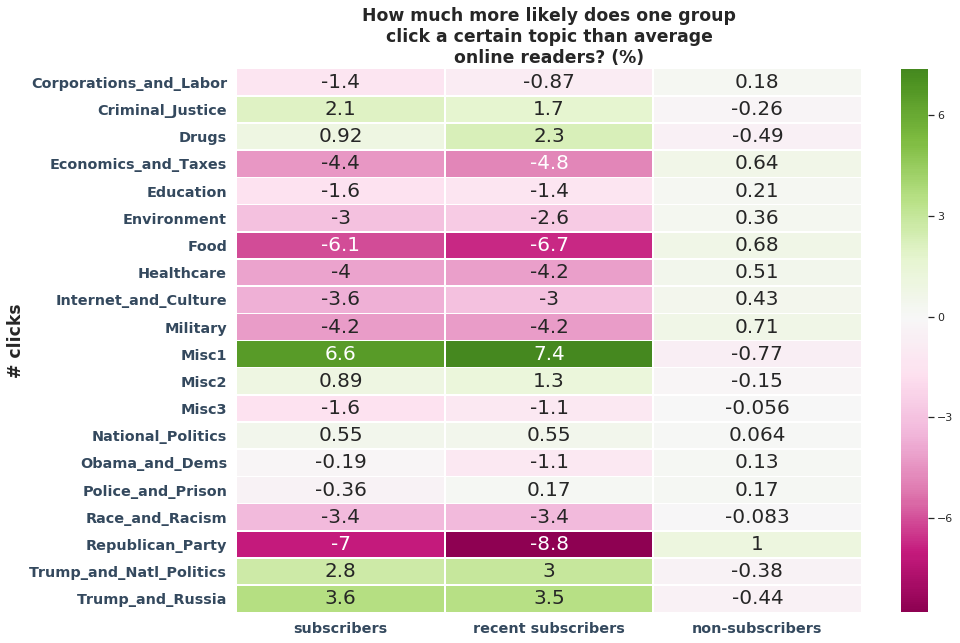

In [64]:
overal_dist =sub_df_colsum(df = mag_news_sub_all,cols = lda_topics, name = 'all readers')/sum(mag_news_sub_all[lda_topics].sum(axis =0))
combo_index = combo.copy()

for g in comparison_groups:
      combo_index[g] = 100*(combo[g]/100/overal_dist - 1)


plot_topic_heatmap(df = combo_index, xlab = "", ylab ="# clicks", 
                   xticklab = ['subscribers','recent subscribers','non-subscribers'], 
                   yticklab = [x.replace('LDA_','') for x in combo_index.index], 
                   title = "\n".join(wrap('How much more likely does one group click a certain topic than average online readers? (%)',40)), 
                   fig_width = 14, fig_height = 10)  
        
        


### d. what's the difference in the most popular titles between online readers who subcribed the magazines within a year, who subscribed the magazines during the newsletter campaign and who didn't subcribe the magazines? (page 25)

In [65]:
def find_most_popular_titles(df, emails, topN = 10):
    """an example of df is click_data from '/home/centos/mojo/newsletter_processed_data.pkl'"""
    temp_data = df.loc[df['Email'].isin(emails)]
    temp_data = temp_data[temp_data['title']!='']


    hoturls = temp_data.groupby('title').agg({'Email': pd.Series.nunique})
    hoturls = hoturls.reset_index()
    hoturls = hoturls.rename(columns = {'Email':'email_count'})
    hoturls['email_pct'] = round(hoturls['email_count']/len(temp_data['Email'].unique())*100,2)
    topN_urls = hoturls.sort_values(by='email_count', ascending=False).head(topN)
    
    return topN_urls

In [66]:
print("Top 10 clicks from online readers who subcribed the magazines within a year")
find_most_popular_titles(df = click_data, emails = online_reader_groups['magazine subscribers']['Email'])

Top 10 clicks from online readers who subcribed the magazines within a year


,title,email_count,email_pct
1833,trump-nonstop-lies,2999,17.65
1974,vice-president-pence-lawyers-up,2958,17.41
1076,new-yorker-cartoon-hits-at-trumps-fake-time-cover,2787,16.40
1160,paul-ryan-brags-about-giving-public-school-employee-1-50,2713,15.97
1989,watch-trump-shove-nato-leader-get-front-group-photo,2454,14.44
940,leaked-email-trump-models-will-officially-shut-down,2281,13.42
625,flynn-trump-washington-post-russia,2161,12.72
474,donald-trump-jr-s-email-scandal-lands-cover-of-time,2156,12.69
2046,why-bmi-big-fat-scam,2111,12.42
1331,sam-brownback-kansas-tax-cuts-donald-trump,2058,12.11


In [67]:
print("Top 10 clicks from online readers who didn't subcribe the magazines")
find_most_popular_titles(df = click_data, emails = online_reader_groups['non-magazine subscribers']['Email'])

Top 10 clicks from online readers who didn't subcribe the magazines


,title,email_count,email_pct
2449,vice-president-pence-lawyers-up,25357,13.83
2281,trump-nonstop-lies,24779,13.52
1464,paul-ryan-brags-about-giving-public-school-employee-1-50,23912,13.05
332,carrie-fisher-donald-trump,23151,12.63
1356,new-yorker-cartoon-hits-at-trumps-fake-time-cover,23052,12.58
2469,watch-trump-shove-nato-leader-get-front-group-photo,22900,12.49
552,donald-trump-climate-white-house-website,20903,11.40
1679,sam-brownback-kansas-tax-cuts-donald-trump,19531,10.66
1183,leaked-email-trump-models-will-officially-shut-down,18941,10.33
791,flynn-trump-washington-post-russia,18297,9.98


In [68]:
print("Top 10 clicks from online readers who subscribed the magazines during the newsletter campaign")
find_most_popular_titles(df = click_data, emails = online_reader_groups['recent magazine subscribers']['Email'])

Top 10 clicks from online readers who subscribed the magazines during the newsletter campaign


,title,email_count,email_pct
1810,trump-nonstop-lies,2621,18.01
1951,vice-president-pence-lawyers-up,2549,17.52
1061,new-yorker-cartoon-hits-at-trumps-fake-time-cover,2415,16.60
1144,paul-ryan-brags-about-giving-public-school-employee-1-50,2387,16.41
1966,watch-trump-shove-nato-leader-get-front-group-photo,2094,14.39
927,leaked-email-trump-models-will-officially-shut-down,1945,13.37
468,donald-trump-jr-s-email-scandal-lands-cover-of-time,1861,12.79
2023,why-bmi-big-fat-scam,1850,12.72
615,flynn-trump-washington-post-russia,1830,12.58
1980,wells-fargo-accidentally-admits-the-truth-the-republican-tax-bill-has-no-connection-to-its-15-minimum-wage,1794,12.33


## 4.2  What differences and similarities can we find between loyal subscribers and new donors?

Assume: 
- loyal subscribers are people who subscribed magazines two years in a row (assume people renew within a month before the subscription expires)
- new donors are people who first donated during the campaigns.

### a.how many loyal subscribers and new donors clicked newsletter? how much did they donate? (page 26)

In [94]:
loyal_sub = sub_don_click_combined[sub_don_click_combined['subs_range'] > 365-60]

# donors from the month
min_date = datetime.date(2017, 1, 1)
max_date = datetime.date(2018, 11, 30)
old_donors_emails = donation[donation['ORD ENTR DT'] < min_date]['EMAIL'].unique().tolist()
new_donors_emails = donation['EMAIL'][~donation['EMAIL'].isin(old_donors_emails)]

new_donors = sub_don_click_combined[sub_don_click_combined.index.isin(new_donors_emails)]

interested_groups=OrderedDict()
interested_groups['loyal subscribers'] = loyal_sub
interested_groups['new donors'] = new_donors

In [95]:
print("{} % loyal subscribers clicked and {}% donated ${} on average per person".format(
    round(100*((interested_groups['loyal subscribers']['Url'] > 0).mean()),2),
    round(100*((interested_groups['loyal subscribers']['don_freq'] > 0).mean()),2),
    round(interested_groups['loyal subscribers'][interested_groups['loyal subscribers']['don_freq'] > 0]['don_total'].mean(),2)))

25.62 % loyal subscribers clicked and 34.25% donated $155.37 on average per person


In [96]:
print("{} % new donors clicked and donated ${} on average per person".format(
    round(100*((interested_groups['new donors']['Url'] > 0).mean()),2),
    round(interested_groups['new donors']['don_total'].mean(),2)))

27.55 % new donors clicked and donated $70.9 on average per person


### b. compare the number of urls clicked by loyal subscribers and new donors (page 27)

Median values:
group
loyal subscribers    6.0 
new donors           12.0
Name: num_clicks, dtype: float64


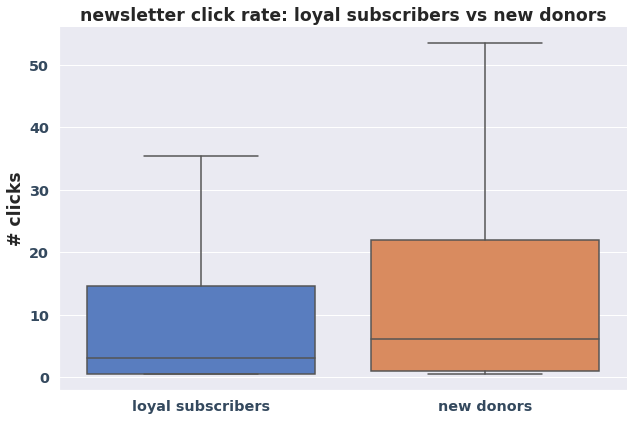

In [98]:
grps = ['loyal subscribers','new donors']

interested_groups_click = {'group':[],'num_clicks': []}

for g in grps:
    interested_groups_click['group'].extend([g]*len(interested_groups[g]))
    interested_groups_click['num_clicks'].extend(interested_groups[g]['Url'])
interested_groups_click_df = pd.DataFrame.from_dict(interested_groups_click)
interested_groups_click_df = interested_groups_click_df[interested_groups_click_df['num_clicks'] != 0]


plot_group_boxplot(x_colname = 'group', y_colname = 'num_clicks', df = interested_groups_click_df,
                      xlab = "", ylab = "# clicks",
                      xticklab = ['loyal subscribers','new donors'], 
                      yticklab = range(-10,int(max(online_reader_groups_click_df['num_clicks'])),10),
                      title = "newsletter click rate: loyal subscribers vs new donors")



In [99]:
interested_groups_click_summary = []

for grpname, dat in interested_groups.items():
    
    interested_groups_click_summary.append(check_click_distribution(df =dat, groupname =grpname))
    
print("compare # urls clicked by loyal subscribers vs new donors ")    
display(pd.concat(interested_groups_click_summary, axis=1))

interested_groups_topics_summary = []

for grpname, dat in interested_groups.items():
    
    interested_groups_topics_summary.append(check_topics_distribution(df =dat, groupname =grpname))
    
print("compare # topics clicked by loyal subscribers vs new donors")    
display(pd.concat(interested_groups_topics_summary, axis=1))

compare # urls clicked by loyal subscribers vs new donors 


,loyal subscribers,new donors
count,7536.00,10613.00
mean,30.32,38.17
std,66.17,68.57
min,1.00,1.00
25%,1.00,2.00
50%,6.00,12.00
75%,29.00,44.00
max,1140.00,1050.00


compare # topics clicked by loyal subscribers vs new donors


,loyal subscribers,new donors
count,7536.00,10613.00
mean,3.23,3.65
std,2.21,2.23
min,1.00,1.00
25%,1.00,1.00
50%,3.00,4.00
75%,5.00,5.00
max,11.00,12.00


### c. compare the topics clicked by loyal subscribers and new donors

### Heatmap with Mojo Topics: loyal subscribers vs new donors (page 28)

               loyal subscribers  new donors
about          0.27               0.20      
crime-justice  0.76               0.80      
environment    19.15              19.64     
food           4.70               5.23      
kevin-drum     11.37              10.79     
media          4.85               4.50      
mixed-media    0.40               0.37      
politics       57.84              57.90     


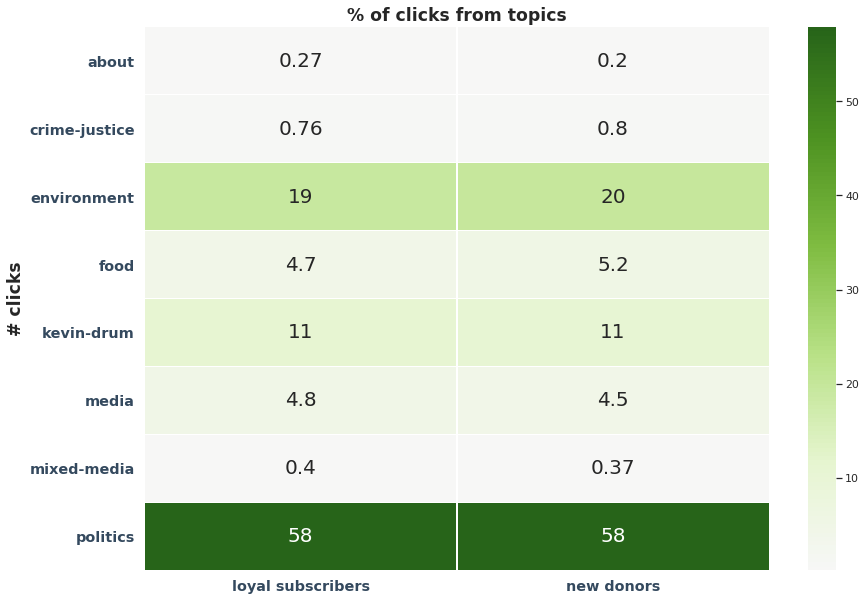

In [100]:
topics = ['about','crime-justice', 'environment', 'food', 'kevin-drum',
       'media', 'mixed-media','politics']
comparison_groups = ['loyal subscribers','new donors']
combo = pd.concat([sub_df_colsum(df = interested_groups[k],cols = topics, name = k) for k in comparison_groups],axis=1)

# convert to click percentage
for g in comparison_groups:
      combo[g] = round(combo[g]/sum(interested_groups[g]['All'])*100,2) 

print(combo)

plot_topic_heatmap(df = combo, xlab = "", ylab ="# clicks", 
                   xticklab = combo.columns, 
                   yticklab = combo.index, 
                   title = "% of clicks from topics", 
                   fig_width = 14, fig_height = 10)  
        


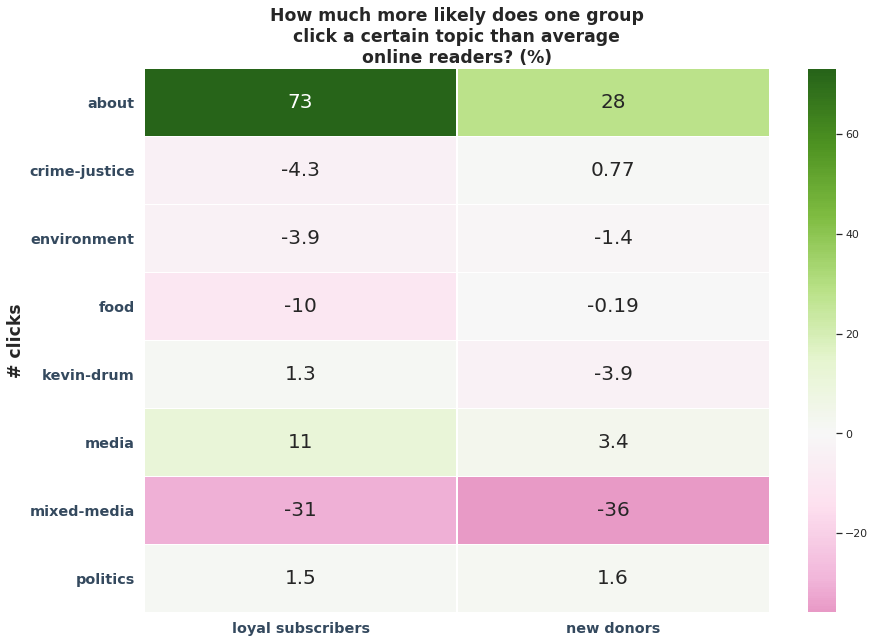

In [101]:
overal_dist =sub_df_colsum(df = mag_news_sub_all,cols = topics, name = 'all readers')/sum(mag_news_sub_all['All'])
combo_index = combo.copy()

for g in comparison_groups:
      combo_index[g] = 100*(combo[g]/100/overal_dist - 1)

        
plot_topic_heatmap(df = combo_index, xlab = "", ylab ="# clicks", 
                   xticklab = combo_index.columns, 
                   yticklab = combo.index, 
                   title = "\n".join(wrap('How much more likely does one group click a certain topic than average online readers? (%)',40)), 
                   fig_width = 14, fig_height = 10)  



### heatmap LDA topic: loyal subscribers vs new donors(page 30)

all the numbers are the percentage of urls containing the certain topics


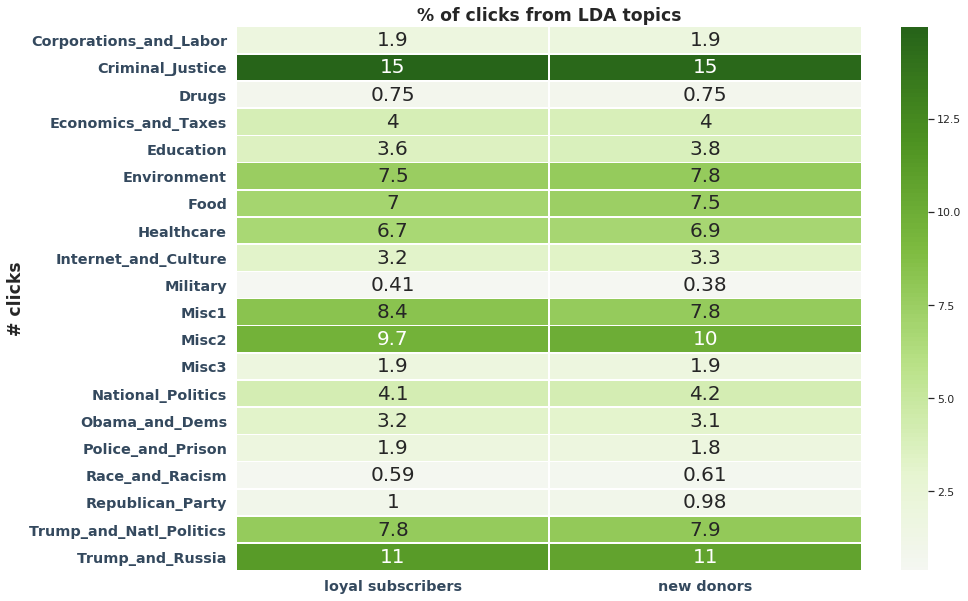

In [102]:
# compare topic click rate

comparison_groups = ['loyal subscribers','new donors']
combo = pd.concat([sub_df_colsum(df = interested_groups[k],cols = lda_topics, name = k) for k in comparison_groups],axis=1)

# convert to click percentage

for g in comparison_groups:
      combo[g] = round(combo[g]/sum(interested_groups[g][lda_topics].sum(axis =0))*100,2) 
     
print('all the numbers are the percentage of urls containing the certain topics')
combo = combo.sort_index()
combo

plot_topic_heatmap(df = combo, xlab = "", ylab ="# clicks", 
                   xticklab = combo.columns, 
                   yticklab = [x.replace('LDA_','') for x in combo.index], 
                   title ="% of clicks from LDA topics", 
                   fig_width = 14, fig_height = 10)  



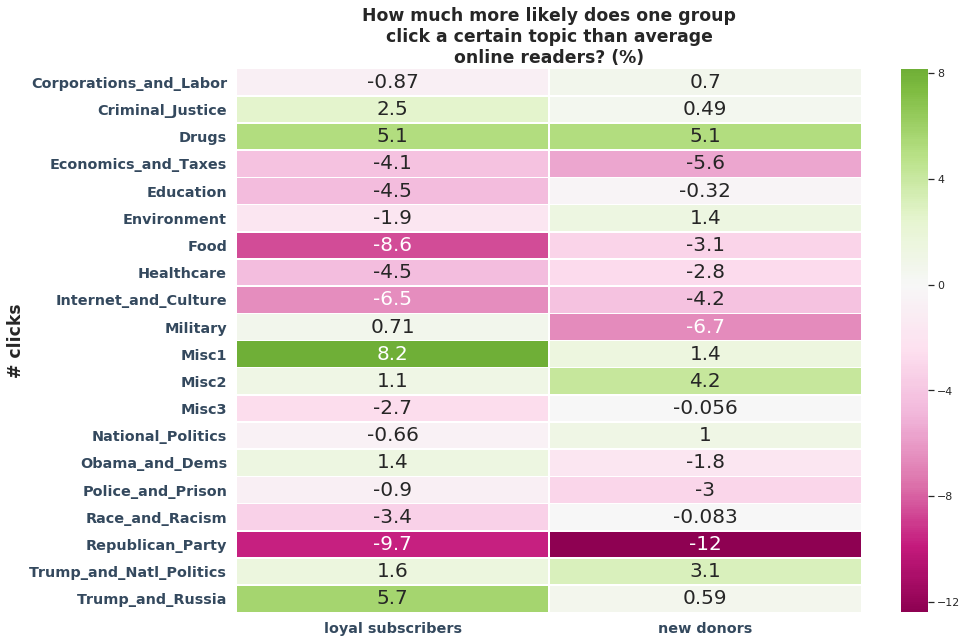

In [103]:
overal_dist =sub_df_colsum(df = mag_news_sub_all,cols = lda_topics, name = 'all readers')/sum(mag_news_sub_all[lda_topics].sum(axis =0))
combo_index = combo.copy()

for g in comparison_groups:
      combo_index[g] = 100*(combo[g]/100/overal_dist - 1)

plot_topic_heatmap(df = combo_index, xlab = "", ylab ="# clicks", 
                   xticklab = combo_index.columns, 
                   yticklab = [x.replace('LDA_','') for x in combo_index.index], 
                   title ="\n".join(wrap('How much more likely does one group click a certain topic than average online readers? (%)',40)), 
                   fig_width = 14, fig_height = 10)  
        
 

In [104]:
print("Top 10 clicks from loyal subscribers")
find_most_popular_titles(df = click_data, emails = interested_groups['loyal subscribers'].index)

Top 10 clicks from loyal subscribers


,title,email_count,email_pct
1723,trump-nonstop-lies,1425,18.97
1862,vice-president-pence-lawyers-up,1358,18.08
1001,new-yorker-cartoon-hits-at-trumps-fake-time-cover,1306,17.39
1082,paul-ryan-brags-about-giving-public-school-employee-1-50,1245,16.58
1876,watch-trump-shove-nato-leader-get-front-group-photo,1157,15.41
875,leaked-email-trump-models-will-officially-shut-down,1084,14.43
448,donald-trump-jr-s-email-scandal-lands-cover-of-time,1011,13.46
1930,why-bmi-big-fat-scam,995,13.25
1247,sam-brownback-kansas-tax-cuts-donald-trump,975,12.98
341,creeping-authoritarianism-trump-trumpocracy,974,12.97


In [105]:
print("Top 10 clicks from new donors")
find_most_popular_titles(df = click_data, emails = interested_groups['new donors'].index)

Top 10 clicks from new donors


,title,email_count,email_pct
1746,trump-nonstop-lies,2424,22.90
1099,paul-ryan-brags-about-giving-public-school-employee-1-50,2166,20.46
1888,vice-president-pence-lawyers-up,2155,20.36
1020,new-yorker-cartoon-hits-at-trumps-fake-time-cover,1979,18.69
1902,watch-trump-shove-nato-leader-get-front-group-photo,1910,18.04
1955,why-bmi-big-fat-scam,1796,16.96
1914,wells-fargo-accidentally-admits-the-truth-the-republican-tax-bill-has-no-connection-to-its-15-minimum-wage,1684,15.91
890,leaked-email-trump-models-will-officially-shut-down,1680,15.87
449,donald-trump-jr-s-email-scandal-lands-cover-of-time,1587,14.99
343,creeping-authoritarianism-trump-trumpocracy,1551,14.65


## 4.3 Compare six different groups of donors and subscribers (page 31)
only have oct campaign data. too little to analyze the factors that lead to donation or subscription

## Presentation summary
- donation:
    - regular donor
    - high-value donor
    - non donor
- subscription
    - print only
    - online only
    - both
    
- compare the six groups:
    - % print sub
    - % online click
    - avg urls
    - avg topics
    - avg donation
    - topic index vs avg online reader
    - top 10 articles vs avg online reader

In [106]:
sub_don_click_combined_temp = combine_dat_sets(combined, 
                                               nclicks_by_users, 
                                               'Email','Email', join_method = 'outer')
all_dat = combine_dat_sets(sub_don_click_combined_temp, 
                            nclicks_by_various_topics,
                             'Email','Email', join_method = 'outer')
all_dat = all_dat.set_index('Email')

In [107]:
def define_interested_groups(df):    
    
    """Take donation data and dive donors into different groups and save data in an ordered dictionary
    
    example 'df' is:
    sub_don_click_combined_filename = '/home/centos/mojo/subscription_donation_click_combined_data.pkl'
    df = pd.read_pickle(sub_don_click_combined_filename)
    """
    
    
    highvalue_donors = df.loc[df['don_total'] >= 500]
    regular_donors = df.loc[(df['don_total'] > 0) & (df['don_total'] < 500)]
    non_donors = df.loc[df['don_total'] == 0]
    
    sub_print_only = df.loc[(df['subs_freq'] >0) & (df['Url'] == 0)]
    sub_online_only = df.loc[(df['subs_freq'] == 0) & (df['Url'] > 0)]
    sub_both = df.loc[(df['subs_freq'] >0) & (df['Url']>0)]
    sub_all_online = df.loc[(df['Url']>0)]
    
    interested_groups=OrderedDict()
    interested_groups['regular donors (< $500)']=regular_donors
    interested_groups['highvalue donors (>= $500)']=highvalue_donors
    interested_groups['non donors']=non_donors
    interested_groups['print subscriber only'] = sub_print_only
    interested_groups['online reader only'] = sub_online_only 
    interested_groups['both print subscriber and online reader'] = sub_both
    interested_groups['all online readers'] = sub_all_online
    return interested_groups

In [108]:
interested_groups = define_interested_groups(df= all_dat)

### compare magazine subscription rate and newsletter click rate by each donor group (page 32)

In [109]:
# subscription rate summary
subscription_rate_summary = []

for grpname, dat in interested_groups.items():
    
    subscription_rate_summary.append(check_subscription_rate(df =dat, groupname =grpname))
    
subscription_rate_summary

subscription_rate_summary_df = pd.DataFrame.from_records(subscription_rate_summary)
subscription_rate_summary_df = subscription_rate_summary_df.rename(columns = {0:'group name',
                                                                    1: 'magazine subscription rate',
                                                                    2: 'newsletter click rate'})

print("compare magazine subscription rate and newsletter click rate by each donor group ")   
subscription_rate_summary_df.iloc[[0,1,2,6]]

compare magazine subscription rate and newsletter click rate by each donor group 


,group name,magazine subscription rate,newsletter click rate
0,regular donors (< $500),32.07,30.20
1,highvalue donors (>= $500),32.73,38.80
2,non donors,25.61,78.78
6,all online readers,8.60,100.00


### compare avg donations by each donor group (page 32)

Median values:
group
all online readers                         50.0
both print subscriber and online reader    60.0
online reader only                         50.0
print subscriber only                      50.0
regular donors (< $500)                    50.0
Name: don_total, dtype: float64


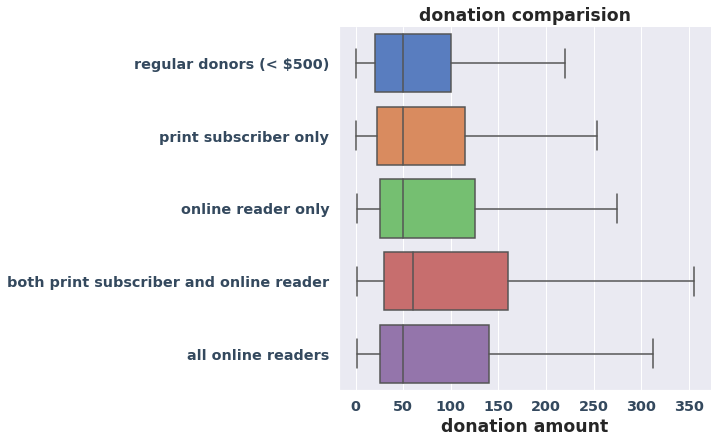

In [133]:
groups_donations = {'group':[],'don_total': []}

for g, dat in interested_groups.items():
    groups_donations['group'].extend([g]*dat.shape[0])
    groups_donations['don_total'].extend(dat['don_total'])

    
groups_donations_df = pd.DataFrame.from_dict(groups_donations)
groups_donations_df = groups_donations_df[groups_donations_df['don_total'] != 0]
groups_donations_df = groups_donations_df[groups_donations_df['group'] != 'highvalue donors (>= $500)']


plot_group_boxplot(x_colname = 'don_total', y_colname = 'group', df = groups_donations_df,
                      xlab = "donation amount", ylab = "",
                      xticklab = [], 
                      yticklab = groups_donations_df['group'].unique(),
                      title = "donation comparision", orient = 'h')




### compare avg clicks from each group (page 33)

In [134]:
click_summary = []

for grpname, dat in interested_groups.items():
    
    click_summary.append(check_click_distribution(df =dat, groupname =grpname))
    
print("compare # urls clicked by each donor group ")    
pd.concat(click_summary, axis=1)


compare # urls clicked by each donor group 


,regular donors (< $500),highvalue donors (>= $500),non donors,print subscriber only,online reader only,both print subscriber and online reader,all online readers
count,20192.00,991.00,179611.00,0.0,183521.00,17273.00,200794.00
mean,39.89,48.35,19.57,NaN,21.14,28.28,21.75
std,74.27,89.91,45.19,NaN,48.37,60.99,49.62
min,1.00,1.00,1.00,NaN,1.00,1.00,1.00
25%,2.00,2.00,2.00,NaN,2.00,2.00,2.00
50%,11.00,10.00,5.00,NaN,5.00,7.00,6.00
75%,45.00,59.00,17.00,NaN,18.00,27.00,19.00
max,1240.00,1245.00,1381.00,NaN,1381.00,1245.00,1381.00


Median values:
group
all online readers                         6.0 
both print subscriber and online reader    7.0 
highvalue donors (>= $500)                 10.0
non donors                                 5.0 
online reader only                         5.0 
regular donors (< $500)                    11.0
Name: Url, dtype: float64


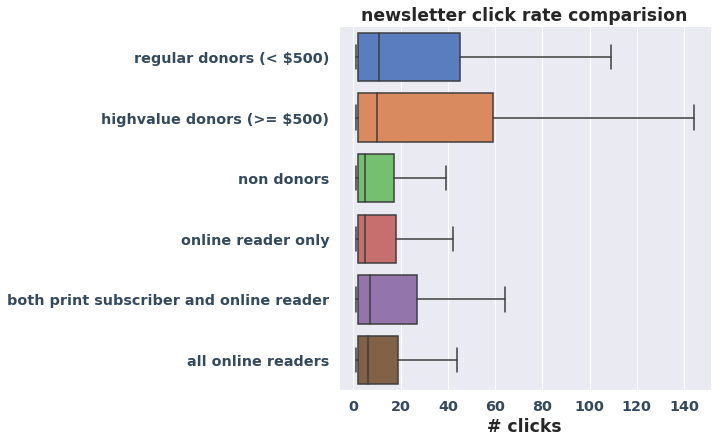

In [135]:
groups_clicks = {'group':[],'Url': []}

for g, dat in interested_groups.items():
    groups_clicks['group'].extend([g]*dat.shape[0])
    groups_clicks['Url'].extend(dat['Url'])

    
groups_clicks_df = pd.DataFrame.from_dict(groups_clicks)
groups_clicks_df = groups_clicks_df[groups_clicks_df['Url'] != 0]

plot_group_boxplot(x_colname = 'Url', 
                    y_colname ='group' , df = groups_clicks_df,
                      xlab = "# clicks", ylab = "",
                      xticklab = [], 
                      yticklab = groups_clicks_df['group'].unique(),
                      title = "newsletter click rate comparision",orient = 'h')



### compare avg number of topics by each donor group

In [136]:
topics_summary = []

for grpname, dat in interested_groups.items():
    
    topics_summary.append(check_topics_distribution(df =dat, groupname =grpname))
    
print("compare # topics clicked by each donor group ")    
display(pd.concat(topics_summary, axis=1))

compare # topics clicked by each donor group 


,regular donors (< $500),highvalue donors (>= $500),non donors,print subscriber only,online reader only,both print subscriber and online reader,all online readers
count,20192.00,991.00,179611.00,0.0,183521.00,17273.00,200794.00
mean,3.65,3.67,3.00,NaN,3.05,3.23,3.07
std,2.31,2.48,1.92,NaN,1.96,2.15,1.98
min,1.00,1.00,1.00,NaN,1.00,1.00,1.00
25%,1.00,1.00,1.00,NaN,1.00,1.00,1.00
50%,3.00,3.00,3.00,NaN,3.00,3.00,3.00
75%,6.00,6.00,4.00,NaN,4.00,5.00,4.00
max,13.00,10.00,17.00,NaN,17.00,12.00,17.00


### compare avg donation by each donor group

In [137]:
def check_avg_donor_rate(df, groupname):
    
    if sum(df['don_total']>0) >0:
        avg_don = round(df['don_total'][df['don_total']>0].median(),2)
    else:
        avg_don = 0
    return (groupname, avg_don)
                    
avg_donation_summary = []

for grpname, dat in interested_groups.items():
    
    avg_donation_summary.append(check_avg_donor_rate(df =dat, groupname =grpname))

avg_donor_summary_df = pd.DataFrame.from_records(avg_donation_summary)
avg_donor_summary_df = avg_donor_summary_df.rename(columns = {0:'group name',
                                                                    1: 'avg donation'})

print("compare average donation amounts by each donor group ")   
avg_donor_summary_df

compare average donation amounts by each donor group 


,group name,avg donation
0,regular donors (< $500),50.0
1,highvalue donors (>= $500),675.0
2,non donors,0.0
3,print subscriber only,50.0
4,online reader only,50.0
5,both print subscriber and online reader,60.0
6,all online readers,50.0


### compare topic click rate and index by each donor group

In [138]:
topics = ['about','crime-justice', 'environment', 'food', 'kevin-drum',
       'media', 'mixed-media','politics']
comparison_groups = interested_groups.keys()
combo = pd.concat([sub_df_colsum(df = interested_groups[k],cols = topics, name = k) for k in comparison_groups],axis=1)

# convert to click percentage
for g in comparison_groups:
      combo[g] = round(combo[g]/sum(interested_groups[g]['All'])*100,2) 

# how much likely the group is to click a topic than average
combo_index = combo.copy()
for c in combo_index.columns:
    combo_index[c] = round((combo_index[c]/combo['all online readers'] - 1)*100,2)

combo_index = combo_index.drop(columns=['print subscriber only','all online readers'])
combo = combo.drop(columns=['print subscriber only'])

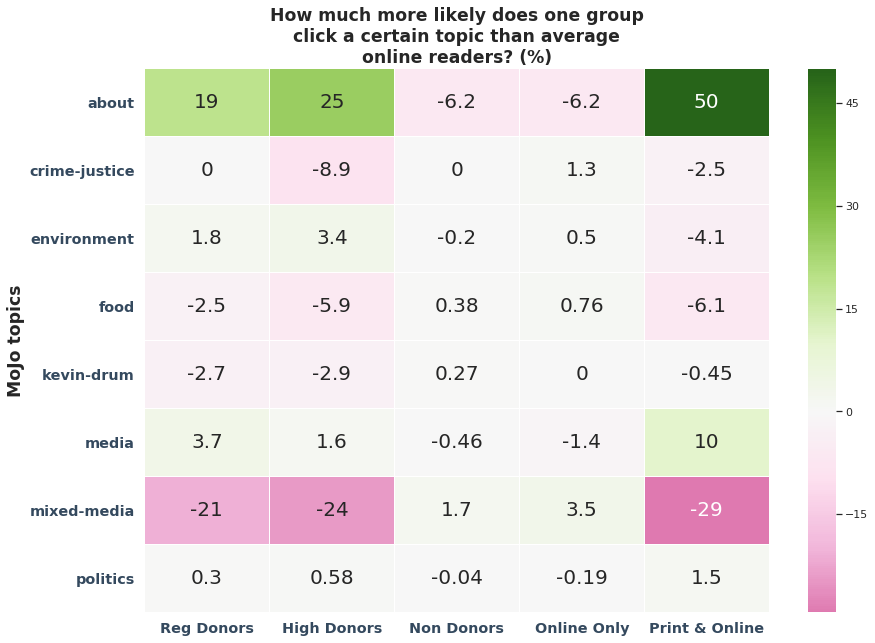

In [140]:
plot_topic_heatmap(df = combo_index.iloc[:,:6], xlab = "", ylab ='MoJo topics', 
                   xticklab = ['Reg Donors','High Donors','Non Donors','Online Only','Print & Online'], 
                   yticklab = combo.index, 
                   title ="\n".join(wrap('How much more likely does one group click a certain topic than average online readers? (%)',40)), 
                   fig_width = 14, fig_height = 10)  
     


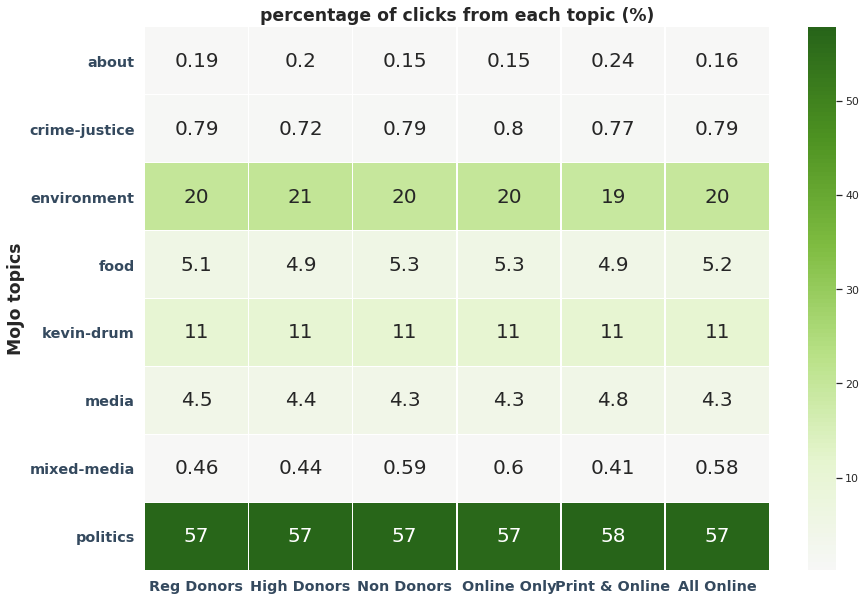

In [141]:

plot_topic_heatmap(df = combo, xlab = "", ylab ='MoJo topics', 
                   xticklab = ['Reg Donors','High Donors','Non Donors','Online Only','Print & Online','All Online'], 
                   yticklab = combo.index, 
                   title ="\n".join(wrap('percentage of clicks from each topic (%)',40)), 
                   fig_width = 14, fig_height = 10)  


### Compare groups’ interests LDA topics (page 37)


all the numbers are the percentage of urls containing the certain topics


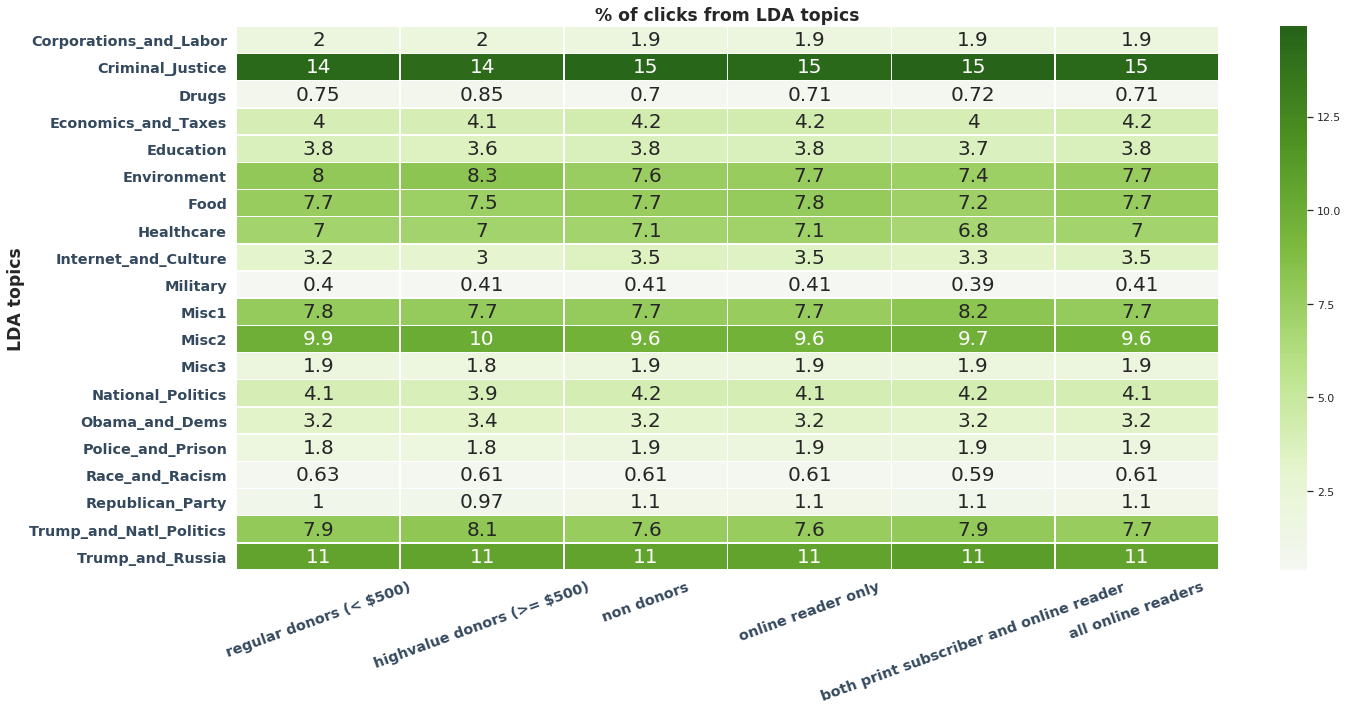

In [148]:
# compare topic click rate

comparison_groups = interested_groups.keys()
combo = pd.concat([sub_df_colsum(df = interested_groups[k],cols = lda_topics, name = k) for k in comparison_groups],axis=1)

# convert to click percentage

for g in comparison_groups:
      combo[g] = round(combo[g]/sum(interested_groups[g][lda_topics].sum(axis =0))*100,2) 
     
print('all the numbers are the percentage of urls containing the certain topics')
combo = combo.sort_index()
#combo_index = combo_index.drop(columns=['print subscriber only','all online readers'])
combo = combo.drop(columns=['print subscriber only'])


plot_topic_heatmap(df = combo, xlab = "", ylab ='LDA topics', 
                   xticklab = combo.columns, 
                   yticklab = [x.replace('LDA_','') for x in combo.index], 
                   title ="% of clicks from LDA topics", 
                   fig_width = 22, fig_height = 10)  


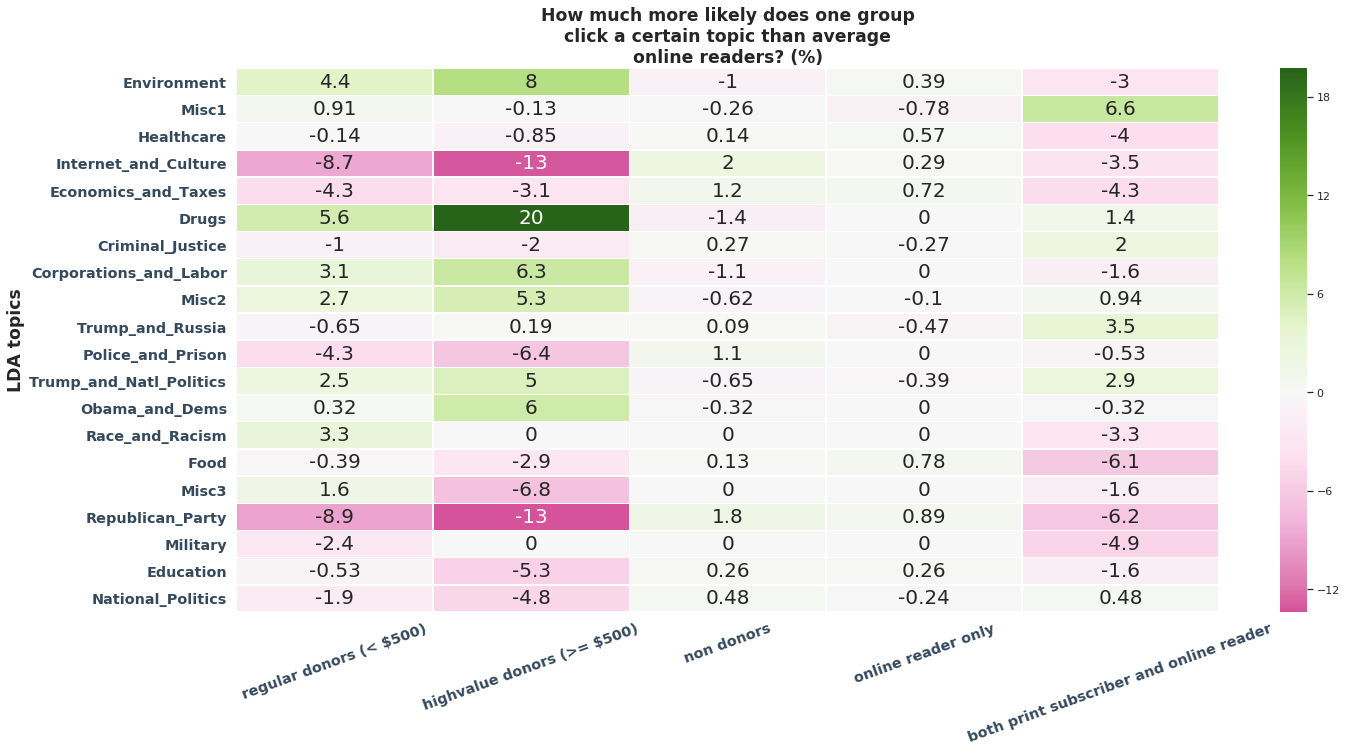

In [149]:
comparison_groups = interested_groups.keys()
combo = pd.concat([sub_df_colsum(df = interested_groups[k],cols = lda_topics, name = k) for k in comparison_groups],axis=1)

# convert to click percentage
for g in comparison_groups:
      combo[g] = round(combo[g]/sum(interested_groups[g][lda_topics].sum(axis=0))*100,2) 

# how much likely the group is to click a topic than average
combo_index = combo.copy()
for c in combo_index.columns:
    combo_index[c] = round((combo_index[c]/combo['all online readers'] - 1)*100,2)

combo_index = combo_index.drop(columns=['print subscriber only','all online readers'])
combo = combo.drop(columns=['print subscriber only'])

plot_topic_heatmap(df = combo_index, xlab = "", ylab ='LDA topics', 
                   xticklab = combo_index.columns, 
                   yticklab = [x.replace('LDA_','') for x in combo_index.index], 
                   title ="\n".join(wrap('How much more likely does one group click a certain topic than average online readers? (%)',40)), 
                   fig_width = 22, fig_height = 10)  



### compare top clicks (page 39)

In [150]:
print("Top 10 clicks from loyal subscribers")
for k in interested_groups.keys():
    print(' #### {}'.format(k))
    display(find_most_popular_titles(df = click_data, emails = interested_groups[k].index)[['title','email_pct']])

Top 10 clicks from loyal subscribers
 #### regular donors (< $500)


,title,email_pct
1954,trump-nonstop-lies,23.14
2109,vice-president-pence-lawyers-up,20.56
2124,watch-trump-shove-nato-leader-get-front-group-photo,19.27
1150,new-yorker-cartoon-hits-at-trumps-fake-time-cover,19.20
1242,paul-ryan-brags-about-giving-public-school-employee-1-50,18.95
288,carrie-fisher-donald-trump,18.31
2185,why-bmi-big-fat-scam,17.23
1002,leaked-email-trump-models-will-officially-shut-down,16.84
1427,sam-brownback-kansas-tax-cuts-donald-trump,16.53
476,donald-trump-climate-white-house-website,16.44


 #### highvalue donors (>= $500)


,title,email_pct
1489,trump-nonstop-lies,25.25
1672,why-bmi-big-fat-scam,21.41
1627,watch-trump-shove-nato-leader-get-front-group-photo,21.31
214,carrie-fisher-donald-trump,21.21
1616,vice-president-pence-lawyers-up,20.61
1084,sam-brownback-kansas-tax-cuts-donald-trump,19.90
872,new-yorker-cartoon-hits-at-trumps-fake-time-cover,19.19
947,paul-ryan-brags-about-giving-public-school-employee-1-50,18.79
1628,watch-young-girl-invite-republican-congressman-her-science-class,18.59
361,donald-trump-climate-white-house-website,18.08


 #### non donors


,title,email_pct
2418,vice-president-pence-lawyers-up,13.38
2254,trump-nonstop-lies,12.77
1442,paul-ryan-brags-about-giving-public-school-employee-1-50,12.63
1337,new-yorker-cartoon-hits-at-trumps-fake-time-cover,12.16
2438,watch-trump-shove-nato-leader-get-front-group-photo,11.87
329,carrie-fisher-donald-trump,11.86
547,donald-trump-climate-white-house-website,10.78
1658,sam-brownback-kansas-tax-cuts-donald-trump,10.08
1168,leaked-email-trump-models-will-officially-shut-down,9.86
783,flynn-trump-washington-post-russia,9.54


 #### print subscriber only


,title,email_pct


 #### online reader only


,title,email_pct
2449,vice-president-pence-lawyers-up,13.82
2281,trump-nonstop-lies,13.51
1464,paul-ryan-brags-about-giving-public-school-employee-1-50,13.04
332,carrie-fisher-donald-trump,12.63
1356,new-yorker-cartoon-hits-at-trumps-fake-time-cover,12.57
2469,watch-trump-shove-nato-leader-get-front-group-photo,12.49
552,donald-trump-climate-white-house-website,11.41
1679,sam-brownback-kansas-tax-cuts-donald-trump,10.66
1183,leaked-email-trump-models-will-officially-shut-down,10.33
791,flynn-trump-washington-post-russia,9.99


 #### both print subscriber and online reader


,title,email_pct
1835,trump-nonstop-lies,17.66
1976,vice-president-pence-lawyers-up,17.47
1077,new-yorker-cartoon-hits-at-trumps-fake-time-cover,16.45
1161,paul-ryan-brags-about-giving-public-school-employee-1-50,15.98
1991,watch-trump-shove-nato-leader-get-front-group-photo,14.45
941,leaked-email-trump-models-will-officially-shut-down,13.43
474,donald-trump-jr-s-email-scandal-lands-cover-of-time,12.66
625,flynn-trump-washington-post-russia,12.64
2048,why-bmi-big-fat-scam,12.45
360,creeping-authoritarianism-trump-trumpocracy,12.10


 #### all online readers


,title,email_pct
2462,vice-president-pence-lawyers-up,14.14
2294,trump-nonstop-lies,13.87
1474,paul-ryan-brags-about-giving-public-school-employee-1-50,13.29
1364,new-yorker-cartoon-hits-at-trumps-fake-time-cover,12.90
2482,watch-trump-shove-nato-leader-get-front-group-photo,12.66
334,carrie-fisher-donald-trump,12.55
555,donald-trump-climate-white-house-website,11.39
1691,sam-brownback-kansas-tax-cuts-donald-trump,10.78
1189,leaked-email-trump-models-will-officially-shut-down,10.60
795,flynn-trump-washington-post-russia,10.21


## 4.4 engagement difference between different donation sources (page 40)

### load source code lookup data

In [152]:
src_lookup = pd.read_csv('/home/centos/mojo/data/SourceCodeIndex_20190213_CM - Source Code Index.csv',keep_default_na=False)

name = []

for i in range(src_lookup.shape[0]):
    temp = src_lookup.iloc[i]
    name.append('_'.join([str(x) for x in temp[1:] if str(x) != 'nan']))
src_lookup['name'] = name

src_p1_lookup = pd.read_csv('/home/centos/mojo/data/ICN FULFILLMENT SOURCE LIST - Sheet1.csv',keep_default_na=False)

### Add source name to donation data
- find the names for the first and second letter of source code
- create column source code tobe the combination of first letter and its name
- filter and keep donation source name only

In [176]:

def return_position1(x):
    if str(x)[0] == 'S':
        return str(x)[:4]
    else:
        return str(x)[0]
    
def return_position2(x):
    y = str(x)
    
    if y[0] == '4':
        if y[1] == 'A':
            return 'Appeals'
        if y[1] == 'R':
            return 'Renewals'
        if y[1:3] == 'LC':
            return 'Sub Conversion'
        if y[1] == 'L':
            return ' Reinstatement'
        if y[1:3] == 'TS':
            return 'Telemarketing Sustainer Invite'
        if y[1:3] == 'PD':
            return 'Planned Giving'
        if y[1] == 'B':
            return 'Sub Inserts'
        if y[1] == 'N':
            return 'Gift Inserts'
        if y[1] == 'U':
            return 'Newsstand Inserts'
        return 'unknown'
    
    if y[0] == '7':
            
        if y[1] in ['9', 'E', 'G', 'H', 'I', 'Z']:
             return 'ICN Web Forms'
        if y[1] in ['C']:
            return 'Convio Web Forms'
        if y[1] in ['P', 'F', 'Q', 'J', 'K']:
            return 'ICN Web Forms'
        if y[1] in ['D']:
            return 'Digital Edition'
        return 'unknown'
    return ''
    

donation2 = donation.copy()
donation2['position1'] = [return_position1(x)  for x in donation2['ORD LST SRC']]

donation2 = donation2.merge(src_p1_lookup, left_on = 'position1', right_on ='position1', how = 'left' ).fillna('unknown')
donation2

donation2 = donation2[donation2['category'].isin(['FUNDRAISING DONATIONS','DONATIONS','unknown'])]
#donation2['position2'] = [return_position2(x)  for x in donation2['ORD LST SRC']]

donation2['name'] = [x.replace('Web Donations, E-Campaigns','Web Donations').replace('Membership Direct Mail Fundraising Promotions','Direct Mail Fundraising') for x in donation2['name']]
donation2['source_name'] = donation2['position1'] + '-' + donation2['name']

### count the total donation of each source and select the sources that account for at least 0.1% of total donations

In [190]:
don_by_src = donation2.groupby('source_name').agg({'AMT PAID':sum,})
don_by_src['AMT PCT'] = don_by_src['AMT PAID']/sum(don_by_src['AMT PAID'])
don_by_src = don_by_src[don_by_src['AMT PCT'] > 0.001]
don_by_src = don_by_src.sort_values('AMT PAID',ascending=False).head(n=10)

print("top donation sources")
print(don_by_src)

,AMT PAID,AMT PCT
source_name,,
7-Web Donations,4025227.89,0.520498
4-Direct Mail Fundraising,1759044.79,0.227460
SUST-sustainer,1626432.10,0.210312
8-Mobile Donations,119119.83,0.015403
I-unknown,97326.00,0.012585
W-White Mail,89038.94,0.011514
R-Phone Orders,15996.55,0.002068


## summarize the click rate of the top donation sources
- plot barplot

Median values:
source_name
4-Direct Mail Fundraising    10.0
7-Web Donations              14.0
8-Mobile Donations           13.0
I-unknown                    24.0
R-Phone Orders               19.5
SUST-sustainer               10.0
W-White Mail                 8.0 
Name: Url, dtype: float64


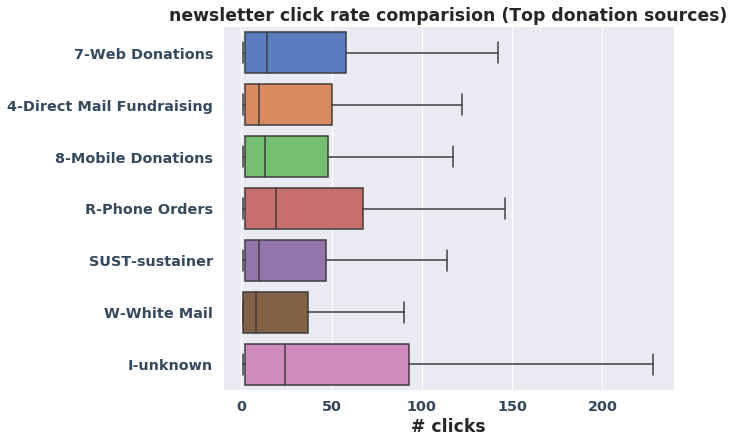

In [193]:
nclicks_by_users = click_data.groupby('Email').agg({'Url': pd.Series.nunique,'topic':pd.Series.nunique})
nclicks_by_users = nclicks_by_users.reset_index()
top_src_emails = donation2[donation2['source_name'].isin(don_by_src.index)]
top_src_emails_click = top_src_emails.merge(nclicks_by_users, left_on = 'EMAIL',right_on = 'Email')

plot_group_boxplot(x_colname = 'Url', y_colname = 'source_name', df = top_src_emails_click,
                      xlab = "# clicks", ylab = "",
                      xticklab = [], yticklab = top_src_emails_click['source_name'].unique(),
                      title = "newsletter click rate comparision (Top donation sources)",
                      orient="h")